# Summary & Problem Statement
This uses data about electricity generation and meteorological data from 2 solar farms somwhere in India. This project has 3 purposes: <br>


1.   Identify panels that need cleaning or maintenance
2.   Identify faulty euqipments
3.   Predict power output for the next 3 days for better grid management




# Load Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
from datetime import datetime
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics
from scipy import stats
from google.colab import drive # this is only required if the code is run on google colab, remove if run on other enviroment
drive.mount('/content/drive') # this is only required if the code is run on google colab, remove if run on other enviroment

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/colab-solar

/content/drive/MyDrive/Github/colab-solar


# Load Data & Preprocessing

In [3]:
dfPower2 = pd.read_csv('./Plant_2_Generation_Data.csv', header = 0, engine = 'c')
dfWeather2 = pd.read_csv('./Plant_2_Weather_Sensor_Data.csv', header = 0, engine = 'c')

## Preliminary Data Description

### Data Sanity Check

In [4]:
def check_column_homo(df):
  colNames = df.columns
  sameDtypeList = []
  dtypeCountList = []
  dtypeList = []
  for col in colNames:
    colDtypeCount = len(set(df[col].map(type)))
    if colDtypeCount == 1:
      sameDtype = True
    else:
      sameDtype = False
    dtypes = list(set(df[col].map(type)))
    sameDtypeList.append(sameDtype)
    dtypeCountList.append(colDtypeCount)
    dtypeList.append(dtypes)
  data = {'is_same_dtype': sameDtypeList,
          'dtype_count': dtypeCountList,
          'dtype_list': dtypeList}
  return pd.DataFrame(data, index = colNames)

def replace_space(df):
  result = deepcopy(df)
  colNames = df.columns
  result.loc[:, colNames] = result.loc[:, colNames].replace (r'^\s+', np.nan, regex=True)
  return result


In [5]:
check_column_homo(dfPower2)

is_same_dtype  dtype_count         dtype_list
DATE_TIME             True            1    [<class 'str'>]
PLANT_ID              True            1    [<class 'int'>]
SOURCE_KEY            True            1    [<class 'str'>]
DC_POWER              True            1  [<class 'float'>]
AC_POWER              True            1  [<class 'float'>]
DAILY_YIELD           True            1  [<class 'float'>]
TOTAL_YIELD           True            1  [<class 'float'>]

In [6]:
check_column_homo(dfWeather2)

is_same_dtype  dtype_count         dtype_list
DATE_TIME                     True            1    [<class 'str'>]
PLANT_ID                      True            1    [<class 'int'>]
SOURCE_KEY                    True            1    [<class 'str'>]
AMBIENT_TEMPERATURE           True            1  [<class 'float'>]
MODULE_TEMPERATURE            True            1  [<class 'float'>]
IRRADIATION                   True            1  [<class 'float'>]

#### Check Null Values & Empty Space
From the be below tests, there are no nulls/missing values in the dataset.



In [7]:
dfPower2 = replace_space(dfPower2)
dfWeather2 = replace_space(dfWeather2)

In [8]:
dfPower2.DATE_TIME = dfPower2.DATE_TIME.astype('datetime64[ns]')
dfWeather2.DATE_TIME = dfWeather2.DATE_TIME.astype('datetime64[ns]')

In [9]:
dfPower2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    67698 non-null  datetime64[ns]
 1   PLANT_ID     67698 non-null  int64         
 2   SOURCE_KEY   67698 non-null  object        
 3   DC_POWER     67698 non-null  float64       
 4   AC_POWER     67698 non-null  float64       
 5   DAILY_YIELD  67698 non-null  float64       
 6   TOTAL_YIELD  67698 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 3.6+ MB


In [10]:
dfPower2.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
0 2020-05-15   4136001  4UPUqMRk7TRMgml       0.0       0.0  9425.000000   
1 2020-05-15   4136001  81aHJ1q11NBPMrL       0.0       0.0     0.000000   
2 2020-05-15   4136001  9kRcWv60rDACzjR       0.0       0.0  3075.333333   
3 2020-05-15   4136001  Et9kgGMDl729KT4       0.0       0.0   269.933333   
4 2020-05-15   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0  3177.000000   

    TOTAL_YIELD  
0  2.429011e+06  
1  1.215279e+09  
2  2.247720e+09  
3  1.704250e+06  
4  1.994153e+07

In [11]:
dfWeather2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3259 non-null   datetime64[ns]
 1   PLANT_ID             3259 non-null   int64         
 2   SOURCE_KEY           3259 non-null   object        
 3   AMBIENT_TEMPERATURE  3259 non-null   float64       
 4   MODULE_TEMPERATURE   3259 non-null   float64       
 5   IRRADIATION          3259 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 152.9+ KB


In [12]:
dfWeather2.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0 2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
1 2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
2 2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
3 2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0            26.500589   
4 2020-05-15 01:00:00   4136001  iq8k7ZNt4Mwm3w0            26.596148   

   MODULE_TEMPERATURE  IRRADIATION  
0           25.060789          0.0  
1           24.421869          0.0  
2           24.427290          0.0  
3           24.420678          0.0  
4           25.088210          0.0

#### Data Description
From below tests, there are no highly unlikely outlier in the datasets. <br>
The PLANT_ID column only contains one unique value since both dataset comes from sensors in one solar farm. It could be removed.

In [13]:
dfPower2.describe()

PLANT_ID      DC_POWER      AC_POWER   DAILY_YIELD   TOTAL_YIELD
count    67698.0  67698.000000  67698.000000  67698.000000  6.769800e+04
mean   4136001.0    246.701961    241.277825   3294.890295  6.589448e+08
std          0.0    370.569597    362.112118   2919.448386  7.296678e+08
min    4136001.0      0.000000      0.000000      0.000000  0.000000e+00
25%    4136001.0      0.000000      0.000000    272.750000  1.996494e+07
50%    4136001.0      0.000000      0.000000   2911.000000  2.826276e+08
75%    4136001.0    446.591667    438.215000   5534.000000  1.348495e+09
max    4136001.0   1420.933333   1385.420000   9873.000000  2.247916e+09

In [14]:
dfWeather2.describe()

PLANT_ID  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
count     3259.0          3259.000000         3259.000000  3259.000000
mean   4136001.0            28.069400           32.772408     0.232737
std          0.0             4.061556           11.344034     0.312693
min    4136001.0            20.942385           20.265123     0.000000
25%    4136001.0            24.602135           23.716881     0.000000
50%    4136001.0            26.981263           27.534606     0.019040
75%    4136001.0            31.056757           40.480653     0.438717
max    4136001.0            39.181638           66.635953     1.098766

In [15]:
max(dfPower2.DATE_TIME)

Timestamp('2020-06-17 23:45:00')

In [16]:
min(dfPower2.DATE_TIME)

Timestamp('2020-05-15 00:00:00')

In [17]:
max(dfWeather2.DATE_TIME)

Timestamp('2020-06-17 23:45:00')

In [18]:
min(dfWeather2.DATE_TIME)

Timestamp('2020-05-15 00:00:00')

In [19]:
len(set(dfPower2.SOURCE_KEY))

22

In [20]:
len(set(dfPower2.SOURCE_KEY))

22

#### Check missing time step

In [21]:
def check_miss_timestep(df, timeCol, maxTime, minTime, interval):
  fullTimeSpan = np.arange(minTime, maxTime + interval, interval).astype('datetime64[ns]')
  dfTimeArray = np.array(df[timeCol]).astype('datetime64[ns]')
  isMissed = not np.array_equal(fullTimeSpan, dfTimeArray)
  if isMissed == True:
    missedSteps = np.array(set(fullTimeSpan) - set(dfTimeArray))
  else:
    missedSteps = np.nan
  return isMissed, missedSteps, fullTimeSpan

In [22]:
def fill_miss_step(df, timeCol, fullTimeSpan, fillValue):
  df = df.set_index(timeCol)
  df = df.reindex(fullTimeSpan, fill_value = fillValue)
  df = df.reset_index()
  return df

In [23]:
def fill_miss_step_value(dfFilled, timeCol, fillType):
  notTimeCol = dfFilled.columns[~dfFilled.columns.isin([timeCol])]
  for col in notTimeCol:
    if fillType == 'back':
      dfFilled[col] = dfFilled[col].bfill()
    elif fillType == 'forward':
      dfFilled[col] = dfFilled[col].ffill()
  return dfFilled

In [24]:
dfWeatherMissed, dfWeatherMissedSteps, dfFullTimeSpan = check_miss_timestep(dfWeather2, 'DATE_TIME',
                                                                            max(dfWeather2.DATE_TIME), min(dfWeather2.DATE_TIME),
                                                                            np.timedelta64(15, 'm'))
dfWeather2Filled = fill_miss_step(dfWeather2, 'DATE_TIME', dfFullTimeSpan, np.nan)

In [25]:
# dfWeather2Filled = fill_miss_step_value(dfWeather2Filled, 'DATE_TIME', 'back')

In [26]:
def split_df_by_col(df, splitCol):
  dfGroup = df.groupby(df[splitCol])
  splitValList = list(set(df[splitCol]))
  listDf = []
  for splitVal in splitValList:
    dfSplit = dfGroup.get_group(splitVal)
    listDf.append(dfSplit)
  return listDf

In [27]:
def fill_split_df_miss_step(df, timeCol, splitCol, maxTime, minTime, interval, fillValue):
  listDf = split_df_by_col(df, splitCol)
  listDfFilled = []
  listMissedStep = []
  listSplitCol = []
  for dfSplit in listDf:
    dfMissed, dfMissedSteps, dfFullSpan = check_miss_timestep(dfSplit, timeCol, maxTime, minTime, interval)
    if dfMissed == True:
      dfSplit = fill_miss_step(dfSplit, timeCol, dfFullSpan, fillValue)
      #dfSplit = fill_miss_step_value(dfSplit, timeCol, fillType)
    else:
      dfSplit = dfSplit
    listDfFilled.append(dfSplit)
    listMissedStep.append(dfMissedSteps)
    listSplitCol.append(list(set(dfSplit[splitCol]))[0])
  return listDfFilled, listMissedStep, listSplitCol

In [28]:
listDfPower2, listMissedPower2, listSplitColPower2 = fill_split_df_miss_step(dfPower2, 'DATE_TIME', 'SOURCE_KEY', max(dfPower2.DATE_TIME),
                                       min(dfPower2.DATE_TIME), np.timedelta64(15, 'm'),
                                       np.nan)

## Merge Weather and Power Datasets

In [29]:
def extend_datetime(df, timeGranularity, timeCol):
  dates = df[timeCol].to_numpy()
  Y, M, D, h, m, s = [dates.astype('datetime64[%s]' % kind) for kind in 'YMDhms']

  years = Y.astype(int) + 1970
  months = M.astype(int) % 12 + 1
  days = (D - M).astype(int) + 1
  hours = (h - D).astype(int)
  minutes = (m - h).astype(int)
  seconds = (s - m).astype(int)
  time_of_day = pd.to_datetime(dates).time

  if 'year' in timeGranularity:
    df['year'] = years
  if 'month' in timeGranularity:
    df['month'] = months
  if 'day' in timeGranularity:
    df['day'] = days
  if 'hour' in timeGranularity:
    df['hour'] = hours
  if 'minute' in timeGranularity:
    df['minute'] = minutes
  if 'second' in timeGranularity:
    df['second'] = seconds
  if 'time_of_day' in timeGranularity:
    df['time_of_day'] = time_of_day
  
  return df

In [30]:
def merge_df_list(listDf, df, key, renameCols, dropCols):
  listDfMerged = []
  for dfSplit in listDf:
    dfSplitJoin = pd.merge(left = dfSplit, right = df, on=key)
    dfSplitJoin = dfSplitJoin.rename(columns = renameCols)
    dfSplitJoin = dfSplitJoin.drop(columns = dropCols)
    listDfMerged.append(dfSplitJoin)
  return listDfMerged

In [31]:
def extend_time_list(listDf, timeCol, timeGranularity):
  listDfExtend = []
  for dfSplit in listDf:
    dfSplitExtendTime = extend_datetime(dfSplit, timeGranularity, timeCol)
    listDfExtend.append(dfSplitExtendTime)
  return listDfExtend

In [32]:
listDfPowerMerged = merge_df_list(listDfPower2, dfWeather2Filled, 'DATE_TIME', 
                                {"SOURCE_KEY_x":"Inverter_ID"},
                                ['PLANT_ID_y','SOURCE_KEY_y','PLANT_ID_x'])

In [33]:
listDfPowerMerged = extend_time_list(listDfPowerMerged, 'DATE_TIME', ['month', 'day', 'hour', 'time_of_day'])

In [34]:
listDfPowerMerged[0]

DATE_TIME      Inverter_ID  DC_POWER  AC_POWER  DAILY_YIELD  \
0    2020-05-15 00:00:00  Et9kgGMDl729KT4       0.0       0.0   269.933333   
1    2020-05-15 00:15:00  Et9kgGMDl729KT4       0.0       0.0     0.000000   
2    2020-05-15 00:30:00  Et9kgGMDl729KT4       0.0       0.0     0.000000   
3    2020-05-15 00:45:00  Et9kgGMDl729KT4       0.0       0.0     0.000000   
4    2020-05-15 01:00:00  Et9kgGMDl729KT4       0.0       0.0     0.000000   
...                  ...              ...       ...       ...          ...   
3259 2020-06-17 22:45:00  Et9kgGMDl729KT4       0.0       0.0  4020.000000   
3260 2020-06-17 23:00:00  Et9kgGMDl729KT4       0.0       0.0  4020.000000   
3261 2020-06-17 23:15:00  Et9kgGMDl729KT4       0.0       0.0  4020.000000   
3262 2020-06-17 23:30:00  Et9kgGMDl729KT4       0.0       0.0  4020.000000   
3263 2020-06-17 23:45:00  Et9kgGMDl729KT4       0.0       0.0  4020.000000   

      TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
0       1704250.0            27.004764           25.060789          0.0   
1       1704250.0            26.880811           24.421869          0.0   
2       1704250.0            26.682055           24.427290          0.0   
3       1704250.0            26.500589           24.420678          0.0   
4       1704250.0            26.596148           25.088210          0.0   
...           ...                  ...                 ...          ...   
3259    1854162.0            23.511703           22.856201          0.0   
3260    1854162.0            23.482282           22.744190          0.0   
3261    1854162.0            23.354743           22.492245          0.0   
3262    1854162.0            23.291048           22.373909          0.0   
3263    1854162.0            23.202871           22.535908          0.0   

      month  day  hour time_of_day  
0         5   15     0    00:00:00  
1         5   15     0    00:15:00  
2         5   15     0    00:30:00  
3         5   15     0    00:45:00  
4         5   15     1    01:00:00  
...     ...  ...   ...         ...  
3259      6   17    22    22:45:00  
3260      6   17    23    23:00:00  
3261      6   17    23    23:15:00  
3262      6   17    23    23:30:00  
3263      6   17    23    23:45:00  

[3264 rows x 13 columns]

# Exploratory Analysis

## Correlation Matrix
From below correlation matrix, we could observe:


1.   AC and DC power output are linear correlated
2.   Irradiation is the most positively correlated factor to power output, while module temperature and ambient temperature also have strong positive correlation to power output




In [35]:
corr = pd.concat(listDfPowerMerged).corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


## Histogram of Each Column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb112ee7950>,
      dtype=object)

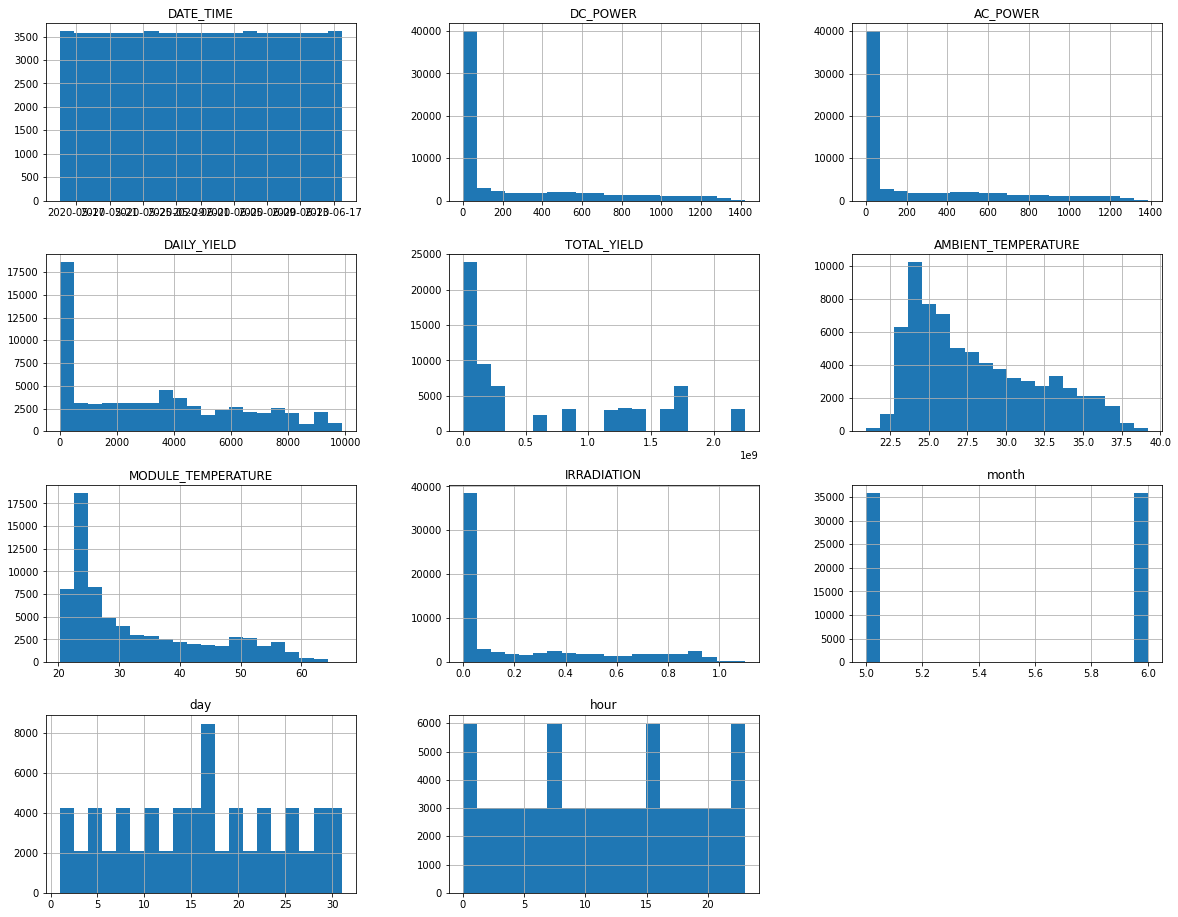

In [36]:
pd.concat(listDfPowerMerged).hist(bins = 20, figsize = (20,16))

In [37]:
dfPowerMerged = pd.concat(listDfPowerMerged)

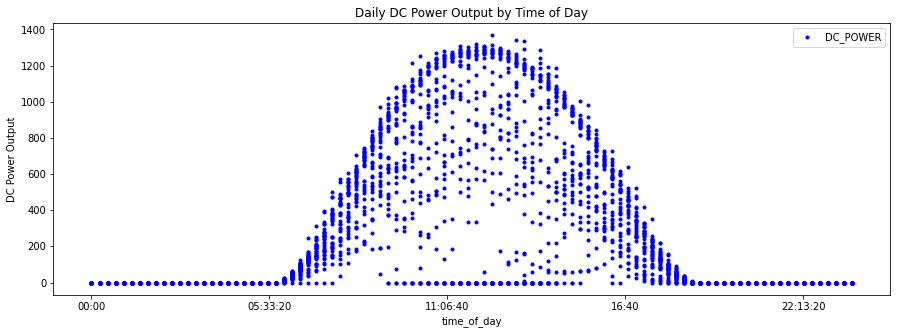

In [38]:
listDfPowerMerged[3].plot(x='time_of_day', y = 'DC_POWER' , style='b.', figsize=(15,5))
#listDfPowerMerged[0].groupby('time')['Light_conversion'].agg('mean').plot(legend=True, colormap='Reds_r')
plt.title('Daily DC Power Output by Time of Day')
plt.ylabel('DC Power Output')
plt.show()

## Plot Power Output over Time of Day for Each Inverter

In [39]:
import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%H:%M')

def subplot_by_col(df, splitCol, nrows, ncols, figsize, title, xCol, yCol, xformatter_):
  grouped = df[[xCol, yCol, splitCol]].groupby(splitCol)
  fig, axs = plt.subplots(figsize=figsize, 
                          nrows=nrows, ncols=ncols,     # fix as above
                          gridspec_kw=dict(hspace=0.4),
                          sharey=True) # Much control of gridspec                       
  targets = zip(grouped.groups.keys(), axs.flatten())
  today = datetime.now().date()
  for i, (key, ax) in enumerate(targets):
    x_dt = [ datetime.combine(today, t) for t in grouped.get_group(key)[xCol]]
    ax.scatter(x_dt, grouped.get_group(key)[yCol])
    ax.set_title(title + splitCol + ' {}'.format(key))
    ax.xaxis.set_major_formatter(xformatter_)
  ax.legend()
  plt.show()


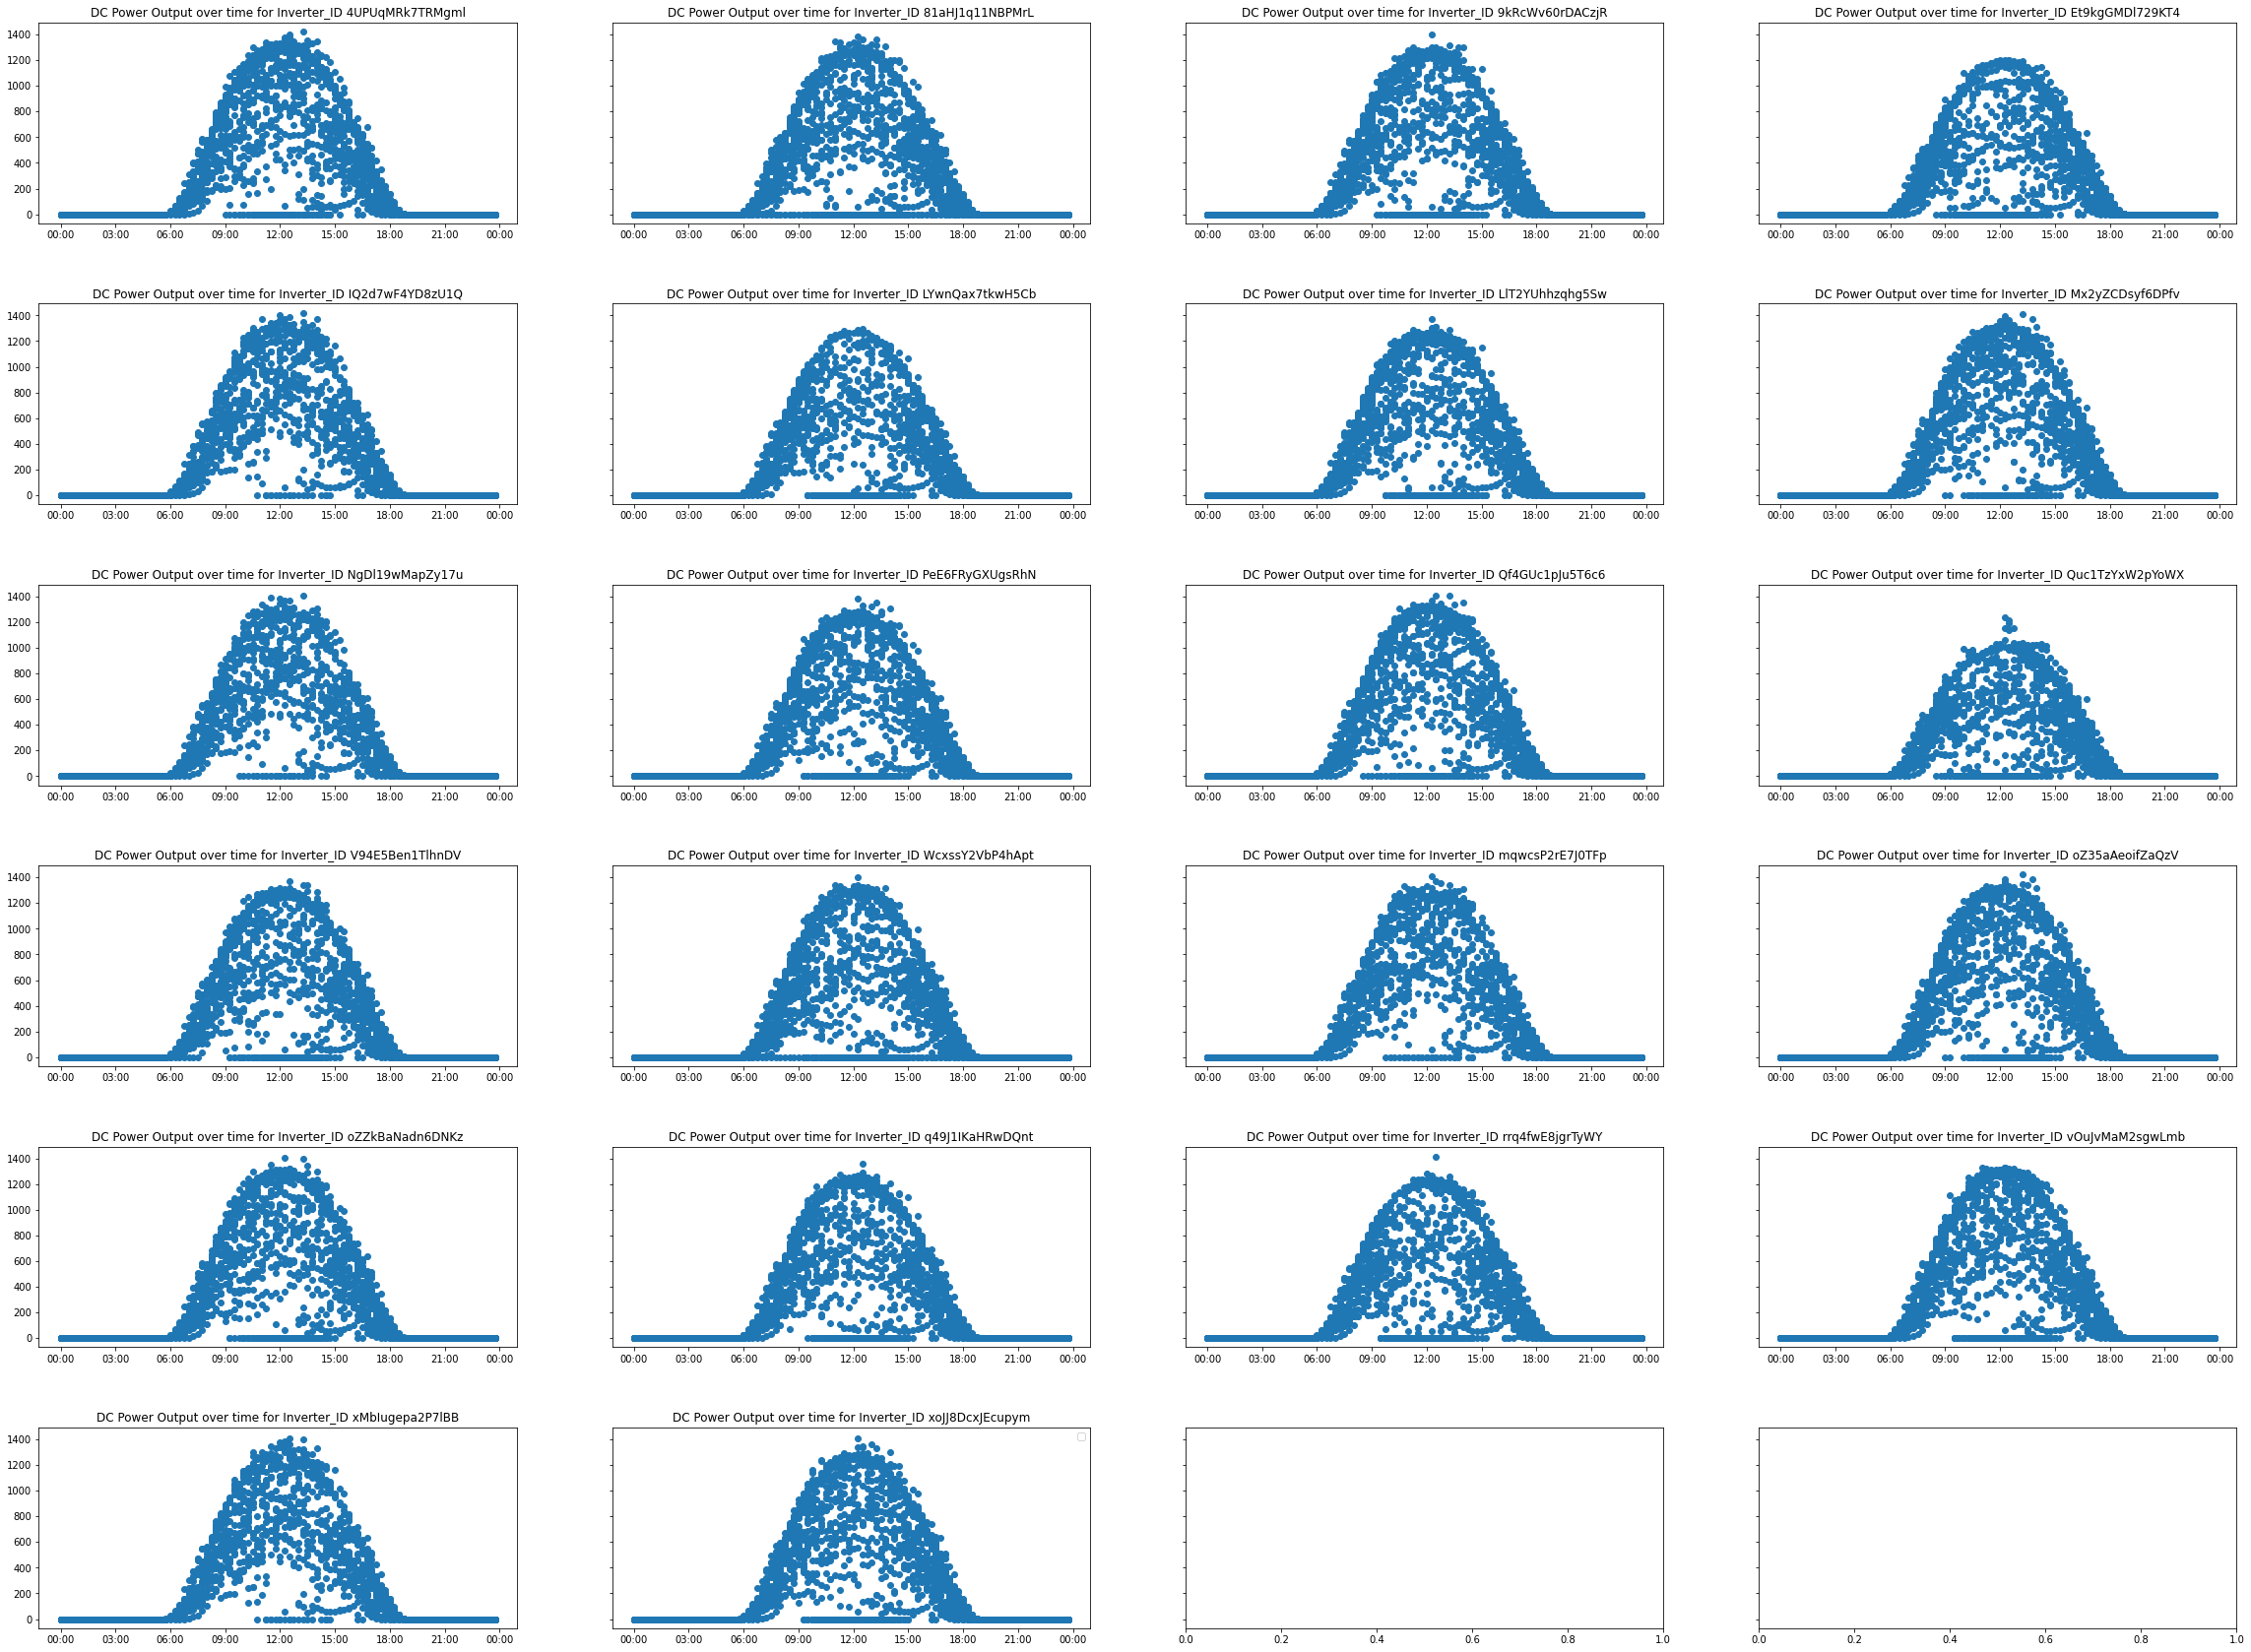

In [40]:
subplot_by_col(dfPowerMerged, 'Inverter_ID', 6, 4, (40,30), 'DC Power Output over time for ', 'time_of_day', 'DC_POWER', xformatter)

## Add Additional Variables

In [41]:
dfPowerMerged['Light_Conversion'] = dfPowerMerged['DC_POWER'] / dfPowerMerged['IRRADIATION']
dfPowerMerged['Light_Conversion'] = dfPowerMerged['Light_Conversion'].fillna(0)
dfPowerMerged['DC_Conversion'] = dfPowerMerged['AC_POWER'] / dfPowerMerged['DC_POWER']
dfPowerMerged['DC_Conversion'] = dfPowerMerged['DC_Conversion'].fillna(0)
dfPowerMerged.head()

DATE_TIME      Inverter_ID  DC_POWER  AC_POWER  DAILY_YIELD  \
0 2020-05-15 00:00:00  Et9kgGMDl729KT4       0.0       0.0   269.933333   
1 2020-05-15 00:15:00  Et9kgGMDl729KT4       0.0       0.0     0.000000   
2 2020-05-15 00:30:00  Et9kgGMDl729KT4       0.0       0.0     0.000000   
3 2020-05-15 00:45:00  Et9kgGMDl729KT4       0.0       0.0     0.000000   
4 2020-05-15 01:00:00  Et9kgGMDl729KT4       0.0       0.0     0.000000   

   TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  month  \
0    1704250.0            27.004764           25.060789          0.0      5   
1    1704250.0            26.880811           24.421869          0.0      5   
2    1704250.0            26.682055           24.427290          0.0      5   
3    1704250.0            26.500589           24.420678          0.0      5   
4    1704250.0            26.596148           25.088210          0.0      5   

   day  hour time_of_day  Light_Conversion  DC_Conversion  
0   15     0    00:00:00               0.0            0.0  
1   15     0    00:15:00               0.0            0.0  
2   15     0    00:30:00               0.0            0.0  
3   15     0    00:45:00               0.0            0.0  
4   15     1    01:00:00               0.0            0.0

#### Investigate Irradiation to DC Power conversion efficiency

#### Light Conversion Rate Over Time of Day
From the below graph we could observe that:


1.   For all inverters, light conversion rate generally remain stable within a range of variations over the course of a day
2.  Almost all inverters experience shutdowns (DC Power drop to 0) during peak irradiation hours, some inverters shotdown less than the others



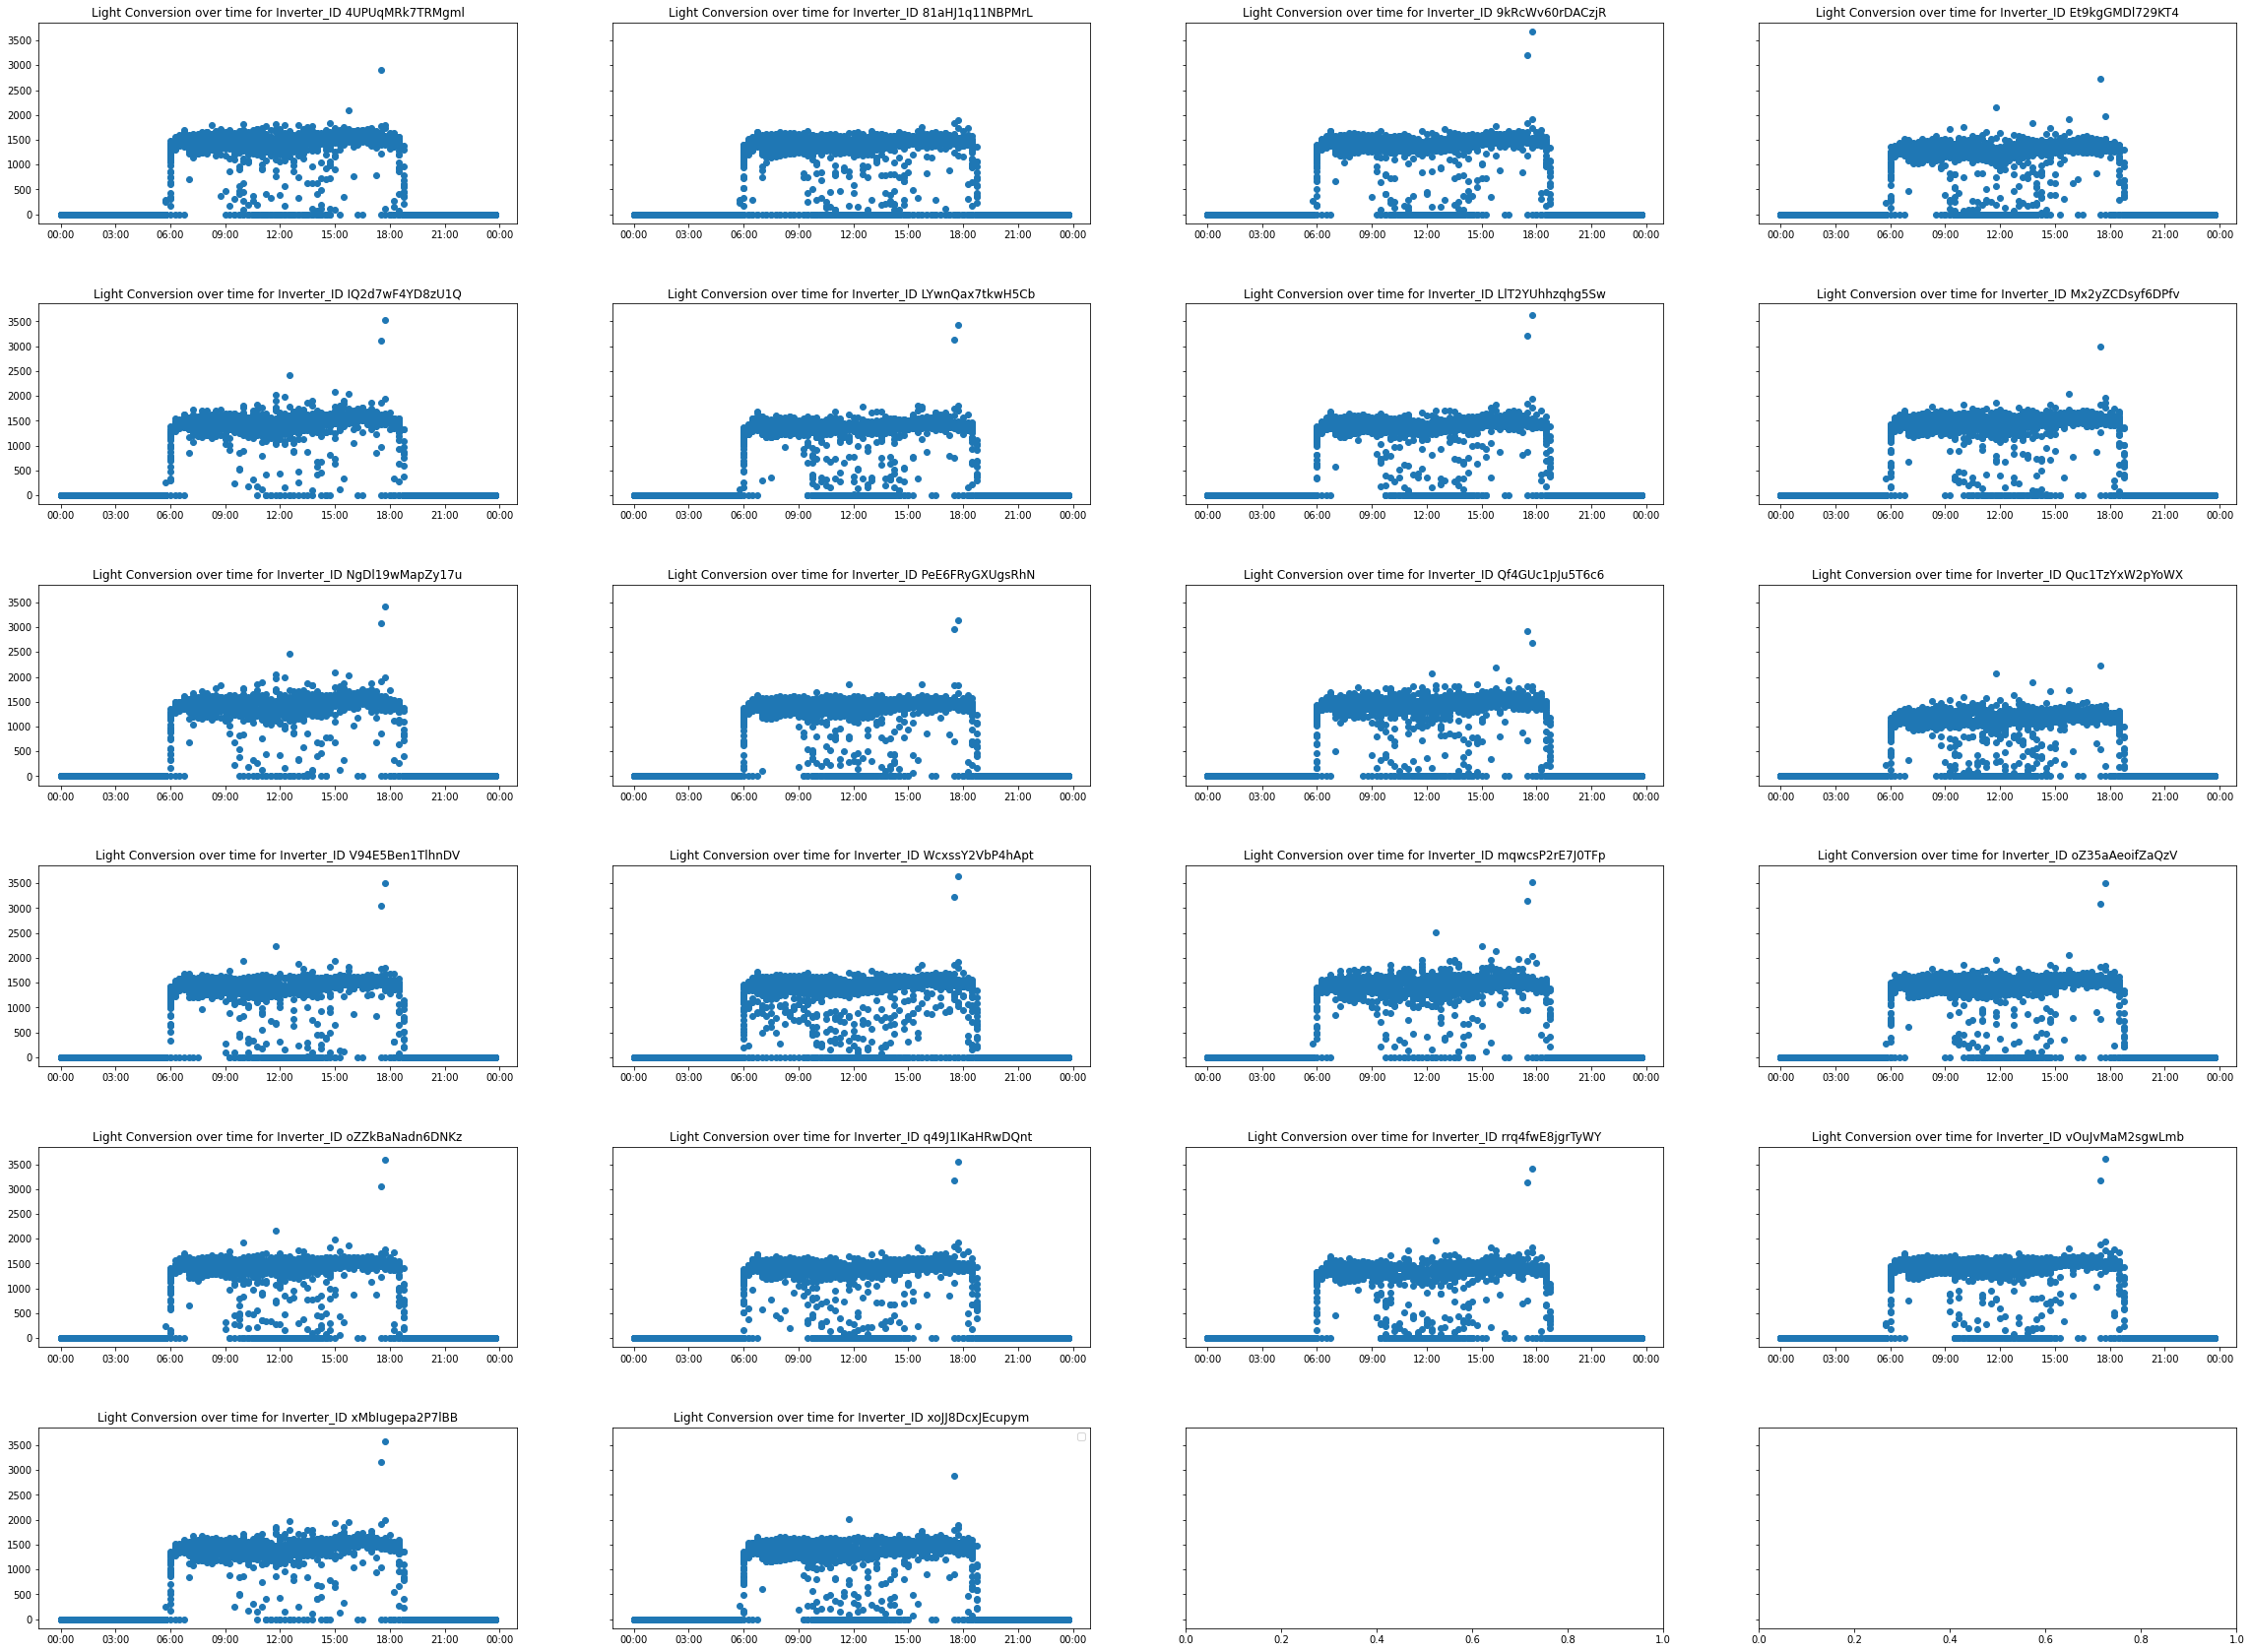

In [42]:
subplot_by_col(dfPowerMerged, 'Inverter_ID', 6, 4, (40,30), 'Light Conversion over time for ', 'time_of_day', 'Light_Conversion', xformatter)

In [43]:
dfPowerMerged['mean_Light_Conversion'] = dfPowerMerged.groupby(by=['Inverter_ID','time_of_day'])['Light_Conversion'].transform('mean')

#### Mean Light Conversion Rate Over Time of Day
Average the light conversion rate for each inverter across 34 days. From the below graph we could observe:


1.   From 6-9AM and 15-18PM the light conversion rate remains stable and high
2.   During 9AM-15PM the light conversion rate decreases to nearly all day low then climbs back
3.   The dip in converion rate during 9AM-15PM could be due to the more often shotdowns during this period 

To fruther investigate the light conversion rate, we should ignore time periods when electricity output is 0 when irradiation is not (shutdowns).



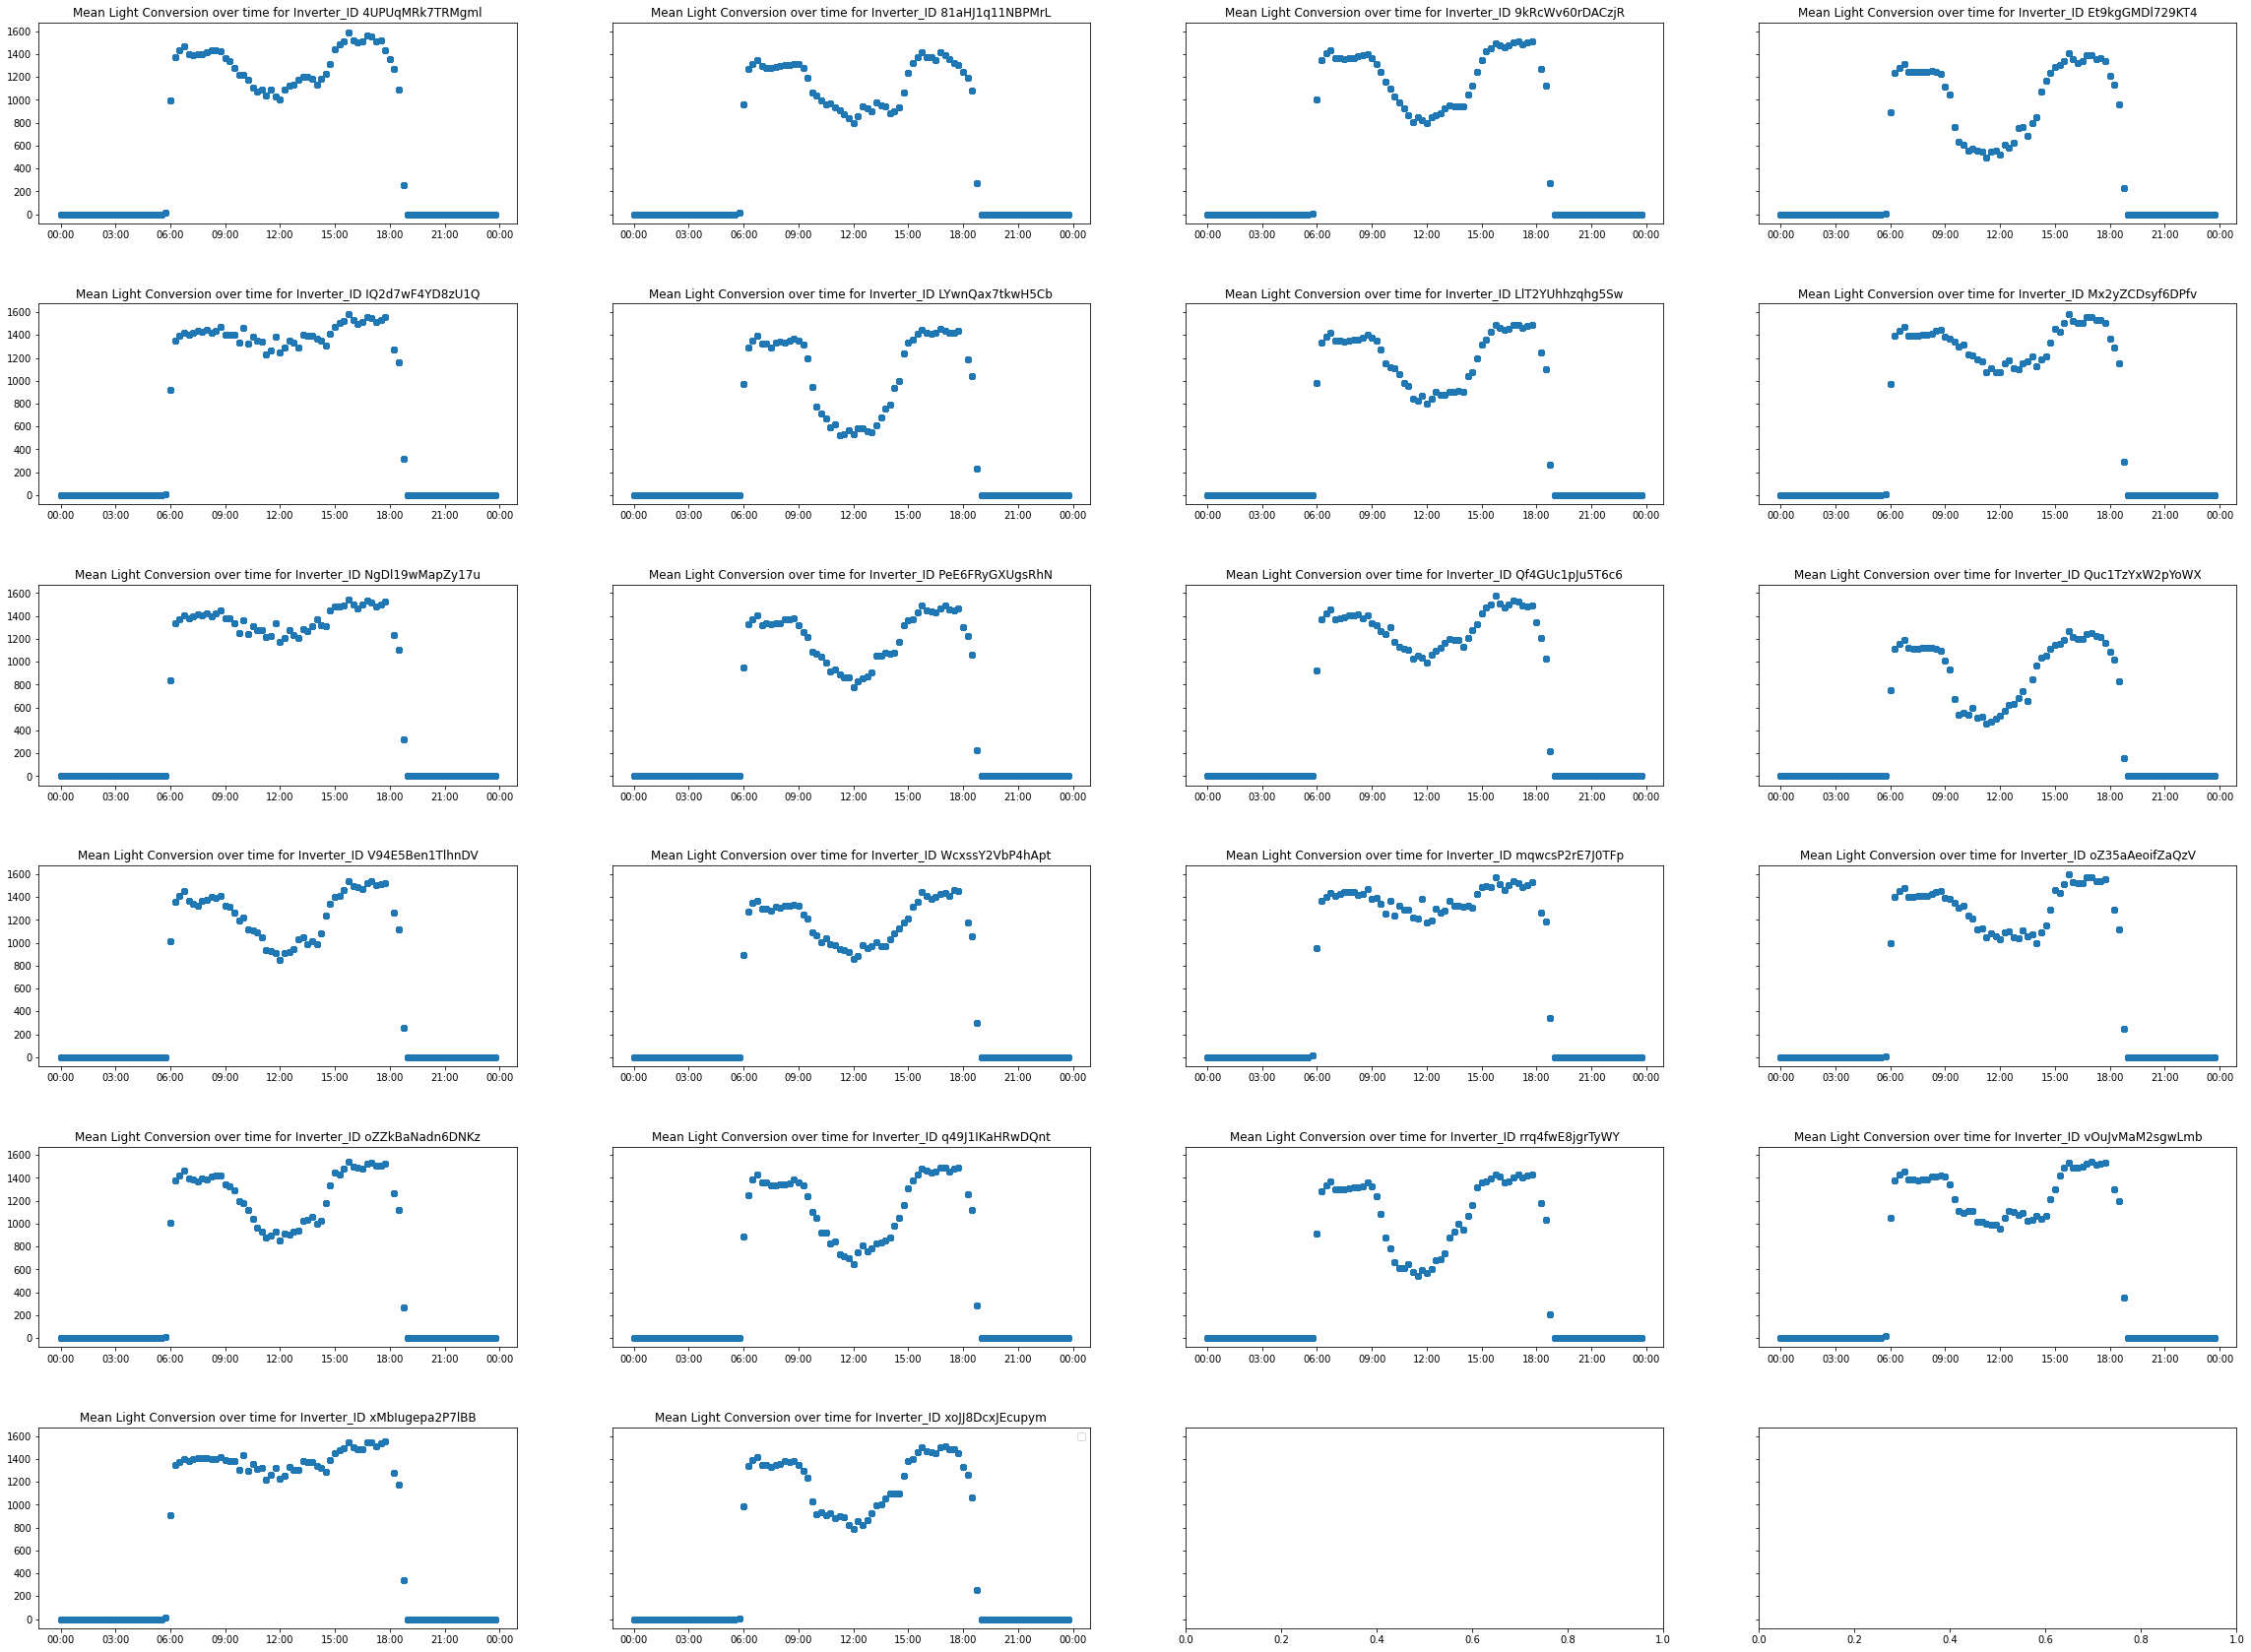

In [44]:
subplot_by_col(dfPowerMerged, 'Inverter_ID', 6, 4, (40,30), 'Mean Light Conversion over time for ', 'time_of_day', 'mean_Light_Conversion', xformatter)

From the above observation, we add another feature called is_peak_hour. For time period between 9AM-15PM we defined the value as True, otherwise False.

In [59]:
dfPowerMerged['is_peak_hour'] = (dfPowerMerged['hour'] >= 9) & (dfPowerMerged['hour'] <=15)

After removing all time period when irradiation is not 0 but power output is (shotdowns) and plot the mean light conversion over time again, we could observe:


1.   Mean light conversion over time of day still reduce during 9AM-15PM for most of inverters after discounting shutdowns
2.   This could be due to the irradiation during peak sun hours exceeds the power generation capacity for the solar panels. Becuase we see though the power generation is not as efficient during the peak hours but the power generation per unit time is still higher during the peak hours



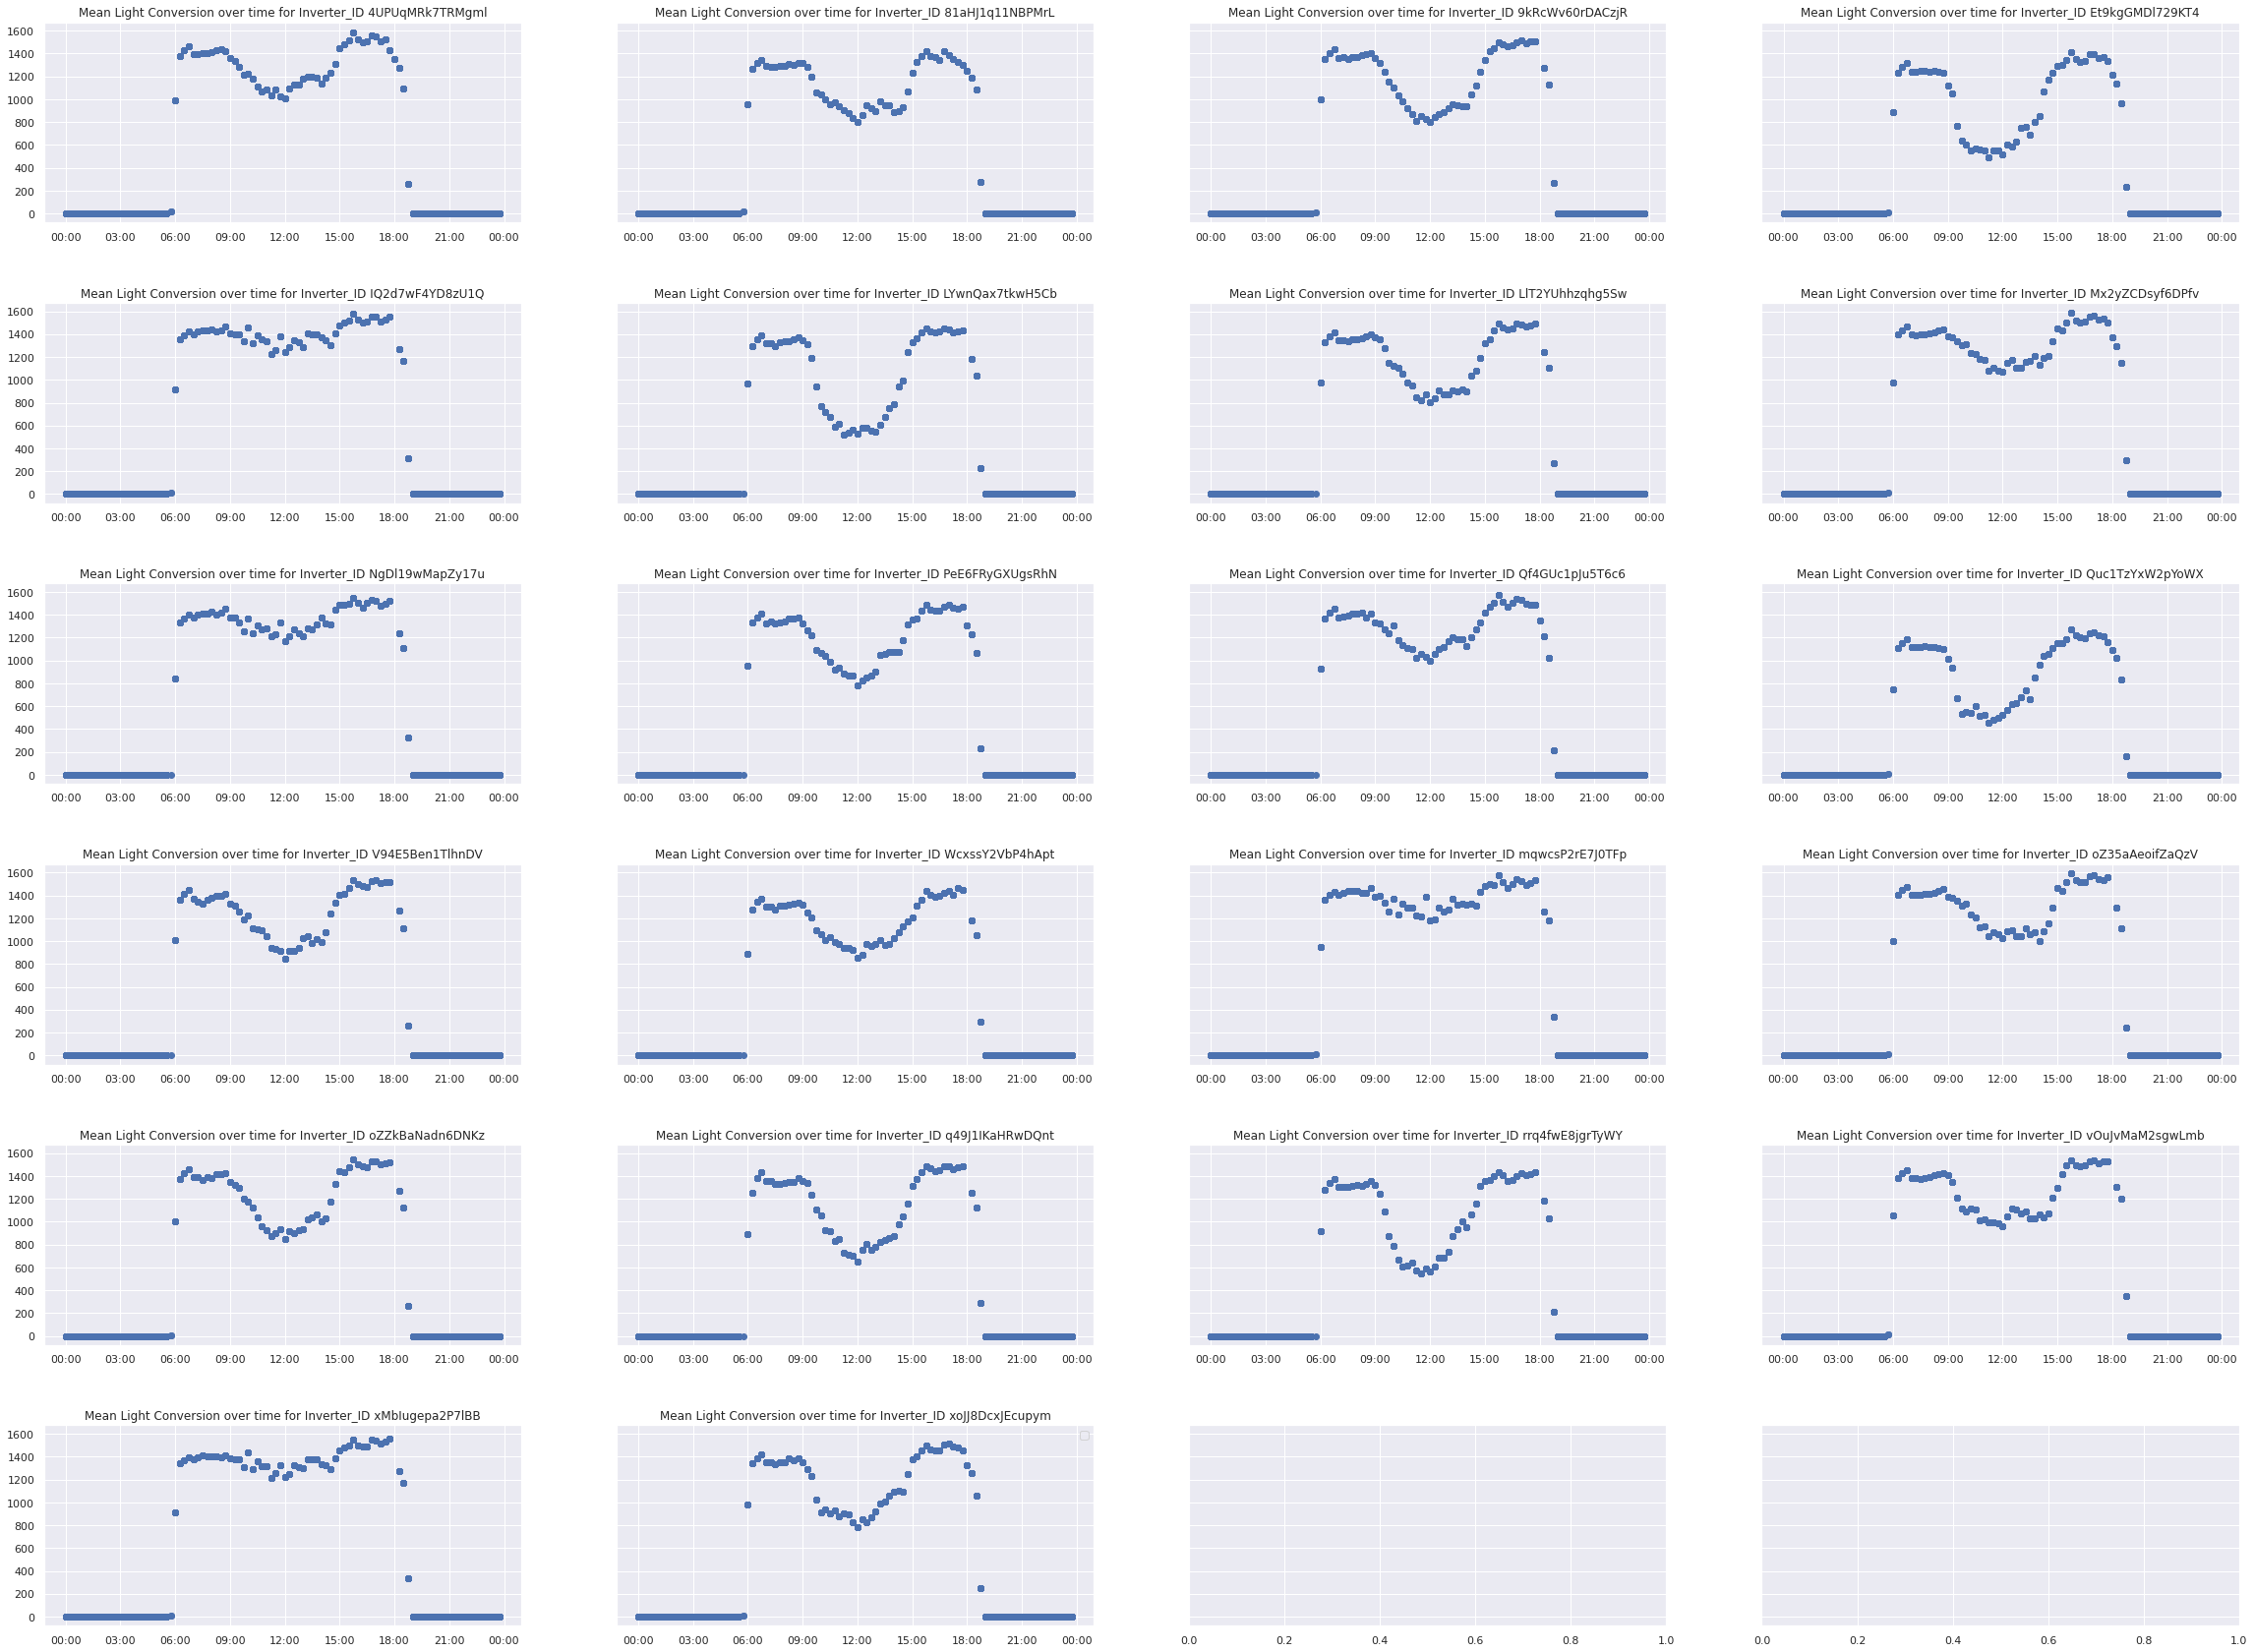

In [60]:
dfPowerMergedRemoveShotDown = dfPowerMerged[(dfPowerMerged['DC_POWER']>0) | (dfPowerMerged['IRRADIATION']==0)]
subplot_by_col(dfPowerMergedRemoveShotDown, 
               'Inverter_ID', 6, 4, (40,30), 'Mean Light Conversion over time for ', 'time_of_day', 'mean_Light_Conversion', xformatter)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text major ticklabel objects>)

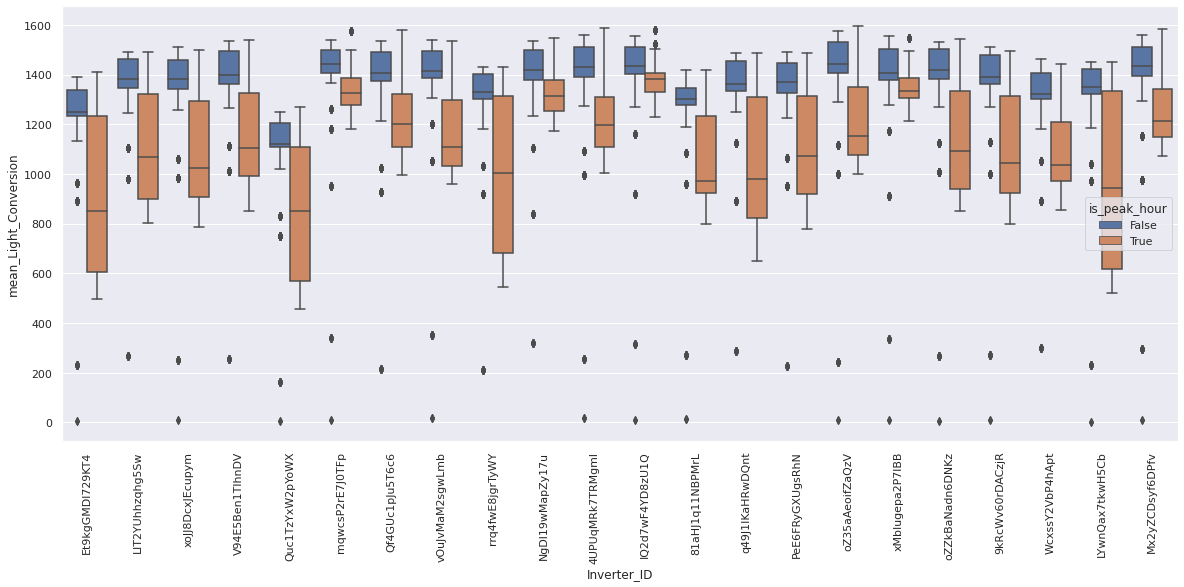

In [61]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(data=dfPowerMergedRemoveShotDown[dfPowerMergedRemoveShotDown['mean_Light_Conversion']>0], 
            x ='Inverter_ID', y='mean_Light_Conversion', hue='is_peak_hour')
plt.xticks(rotation=90)

In [ ]:
df_input = df_merged_2.copy()
df_input = df_input[['AC_POWER','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','month','day_of_month','hour','minute','day_of_week']]

NameError: ignored

In [ ]:
Input = df_input.iloc[:,1:]
Target = df_input.iloc[:,0]
scaler = MinMaxScaler()
Input_scaled = scaler.fit_transform(Input)
Input_scaled  = pd.DataFrame(Input_scaled, columns = Input.columns)
Input_scaled.head()

In [ ]:
X = Input_scaled
Y = Target 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
start_time = timeit.default_timer()
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, 1, 5], 'cache_size':[1000]}
svr = SVR()
clf = GridSearchCV(svr, parameters, n_jobs = -1, scoring = 'neg_mean_squared_error', cv = 3)
best_svr = clf.fit(X_train, Y_train)
elapsed = timeit.default_timer() - start_time

In [ ]:
elapsed

In [ ]:
svr_model = best_svr.best_estimator_
svr_result = svr_model.predict(X_test)

In [ ]:
svr_mse = metrics.mean_squared_error(Y_test, svr_result)
svr_r2 = metrics.r2_score(Y_test, svr_result)
svr_output = {'Model':['SVR'], 'MSE': [svr_mse], 'R2' : [svr_r2]}

In [ ]:
svr_output

In [ ]:
dfX_test = X_test.copy()
dfX_test = dfX_test.reset_index(drop = True)
dfX_test = scaler.inverse_transform(dfX_test)
dfX_test = pd.DataFrame(dfX_test, columns = Input.columns)
dfY_test = Y_test.copy()
dfY_test = dfY_test.reset_index(drop = True)
df_test_real = pd.concat([dfX_test, dfY_test], axis = 1)
svr_pred = pd.DataFrame(svr_result, columns = ['AC_POWER'])
df_test_pred = pd.concat([dfX_test, svr_pred], axis = 1)

In [ ]:
a = dfX_test.reset_index(drop = True)
a.multiply(minmaxdiff, axis = 1)

In [ ]:
# I split dataframe in to multiple dataframes by inverter_ID
# each dataframe after split only consists data for 1 single inverter
# dataframes are stored in a list
inverter_group = df_merged_1.groupby(df_merged_1.Inverter_ID)
list_df_inverter = [] # the list used in
inverter_list = list(set(df_merged_1.Inverter_ID))

In [ ]:
for inv in inverter_list:
    df_temp = inverter_group.get_group(inv)
    list_df_inverter.append(df_temp)

## This plot confirms our assumption
Irradiation & temprature are highly correlated to power output

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# plot correlation matrix on 1 inverter
corr = list_df_inverter[0].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


In [ ]:
sns.pairplot(list_df_inverter[0])

In [ ]:
list_df_inverter[0]

DATE_TIME  PLANT_ID      Inverter_ID    DC_POWER    AC_POWER  \
5     2020-05-15 00:00:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
27    2020-05-15 00:15:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
49    2020-05-15 00:30:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
71    2020-05-15 00:45:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
93    2020-05-15 01:00:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
115   2020-05-15 01:15:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
137   2020-05-15 01:30:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
159   2020-05-15 01:45:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
181   2020-05-15 02:00:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
203   2020-05-15 02:15:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
225   2020-05-15 02:30:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
247   2020-05-15 02:45:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
269   2020-05-15 03:00:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
291   2020-05-15 03:15:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
313   2020-05-15 03:30:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
335   2020-05-15 03:45:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
357   2020-05-15 04:00:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
379   2020-05-15 04:15:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
401   2020-05-15 04:30:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
423   2020-05-15 04:45:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
445   2020-05-15 05:00:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
467   2020-05-15 05:15:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
489   2020-05-15 05:30:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
511   2020-05-15 05:45:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
533   2020-05-15 06:00:00   4136001  LYwnQax7tkwH5Cb   15.566667   15.020000   
555   2020-05-15 06:15:00   4136001  LYwnQax7tkwH5Cb   26.228571   25.328571   
577   2020-05-15 06:30:00   4136001  LYwnQax7tkwH5Cb   59.153333   57.300000   
599   2020-05-15 06:45:00   4136001  LYwnQax7tkwH5Cb  164.406667  160.793333   
621   2020-05-15 07:00:00   4136001  LYwnQax7tkwH5Cb  314.906667  309.426667   
643   2020-05-15 07:15:00   4136001  LYwnQax7tkwH5Cb  385.286667  378.620000   
...                   ...       ...              ...         ...         ...   
67043 2020-06-17 16:30:00   4136001  LYwnQax7tkwH5Cb  275.726667  270.466667   
67065 2020-06-17 16:45:00   4136001  LYwnQax7tkwH5Cb  178.933333  175.193333   
67087 2020-06-17 17:00:00   4136001  LYwnQax7tkwH5Cb   53.086667   51.393333   
67109 2020-06-17 17:15:00   4136001  LYwnQax7tkwH5Cb  133.428571  129.828571   
67131 2020-06-17 17:30:00   4136001  LYwnQax7tkwH5Cb  130.030000  126.510000   
67153 2020-06-17 17:45:00   4136001  LYwnQax7tkwH5Cb   93.040000   90.380000   
67175 2020-06-17 18:00:00   4136001  LYwnQax7tkwH5Cb   57.846667   56.006667   
67197 2020-06-17 18:15:00   4136001  LYwnQax7tkwH5Cb   31.426667   30.360000   
67219 2020-06-17 18:30:00   4136001  LYwnQax7tkwH5Cb   18.400000   17.760000   
67241 2020-06-17 18:45:00   4136001  LYwnQax7tkwH5Cb    2.914286    2.807143   
67263 2020-06-17 19:00:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
67285 2020-06-17 19:15:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
67307 2020-06-17 19:30:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
67329 2020-06-17 19:45:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
67351 2020-06-17 20:00:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
67373 2020-06-17 20:15:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
67395 2020-06-17 20:30:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
67417 2020-06-17 20:45:00   4136001  LYwnQax7tkwH5Cb    0.000000    0.000000   
67439 2020-06-17

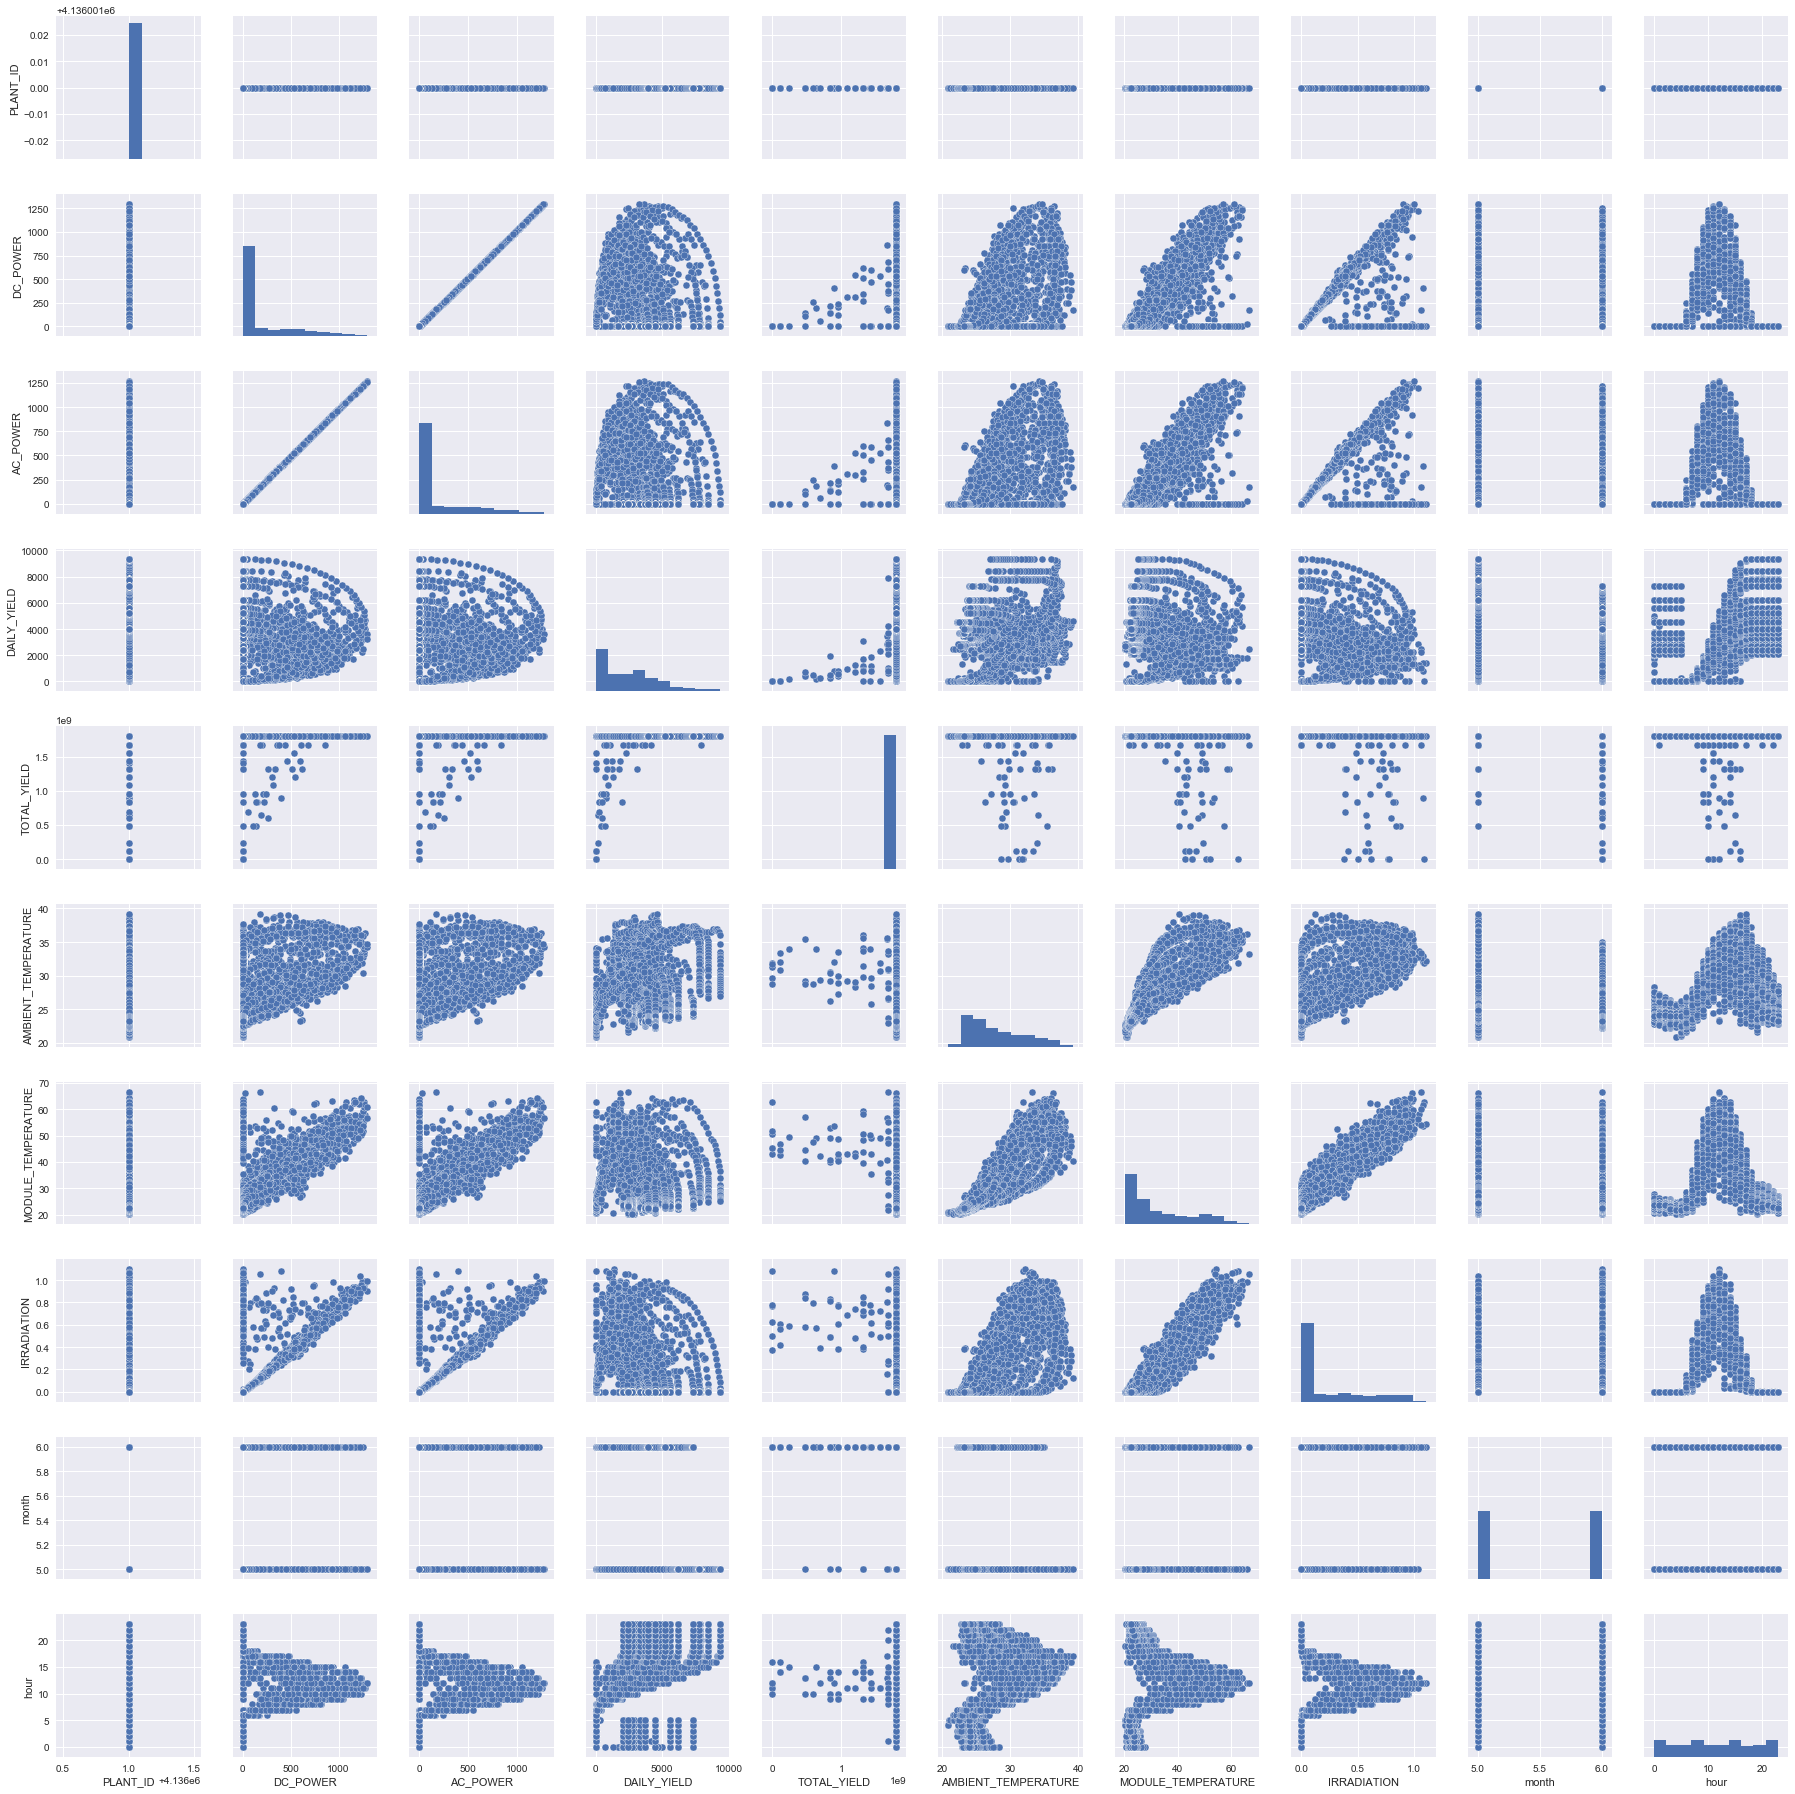

In [ ]:
plt.show()

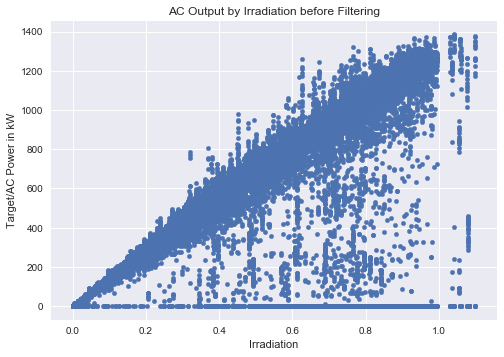

In [ ]:
df_merged_2.plot(x = 'IRRADIATION', y = 'AC_POWER', kind = 'scatter')
plt.xlabel("Irradiation")
plt.ylabel("Target/AC Power in kW")
plt.title("AC Output by Irradiation before Filtering")
plt.show()

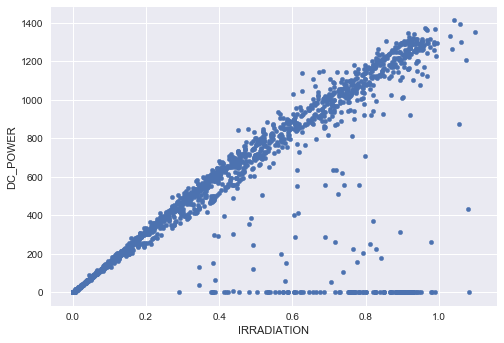

In [ ]:
df_merged_2.loc[df_merged_2['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',:].plot(x = 'IRRADIATION', y = 'DC_POWER', kind = 'scatter')
plt.show()

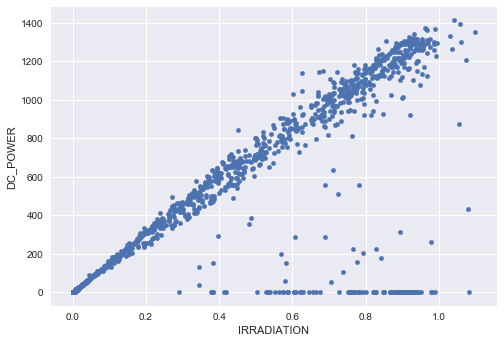

In [ ]:
df_filter.loc[df_filter['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',:].plot(x = 'IRRADIATION', y = 'DC_POWER', kind = 'scatter')
plt.show()

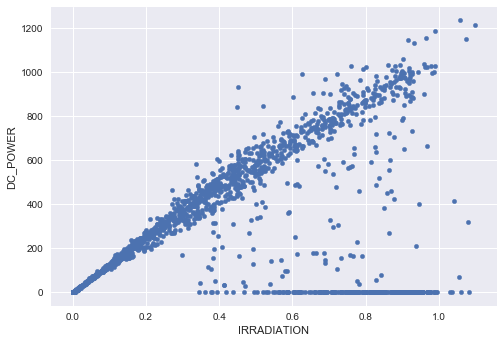

In [ ]:
df_merged_2.loc[df_merged_2['Inverter_ID'] == 'Quc1TzYxW2pYoWX',:].plot(x = 'IRRADIATION', y = 'DC_POWER', kind = 'scatter')
plt.show()

In [ ]:
df_filter.loc[df_filter['Inverter_ID'] == 'Quc1TzYxW2pYoWX',:].plot(x = 'IRRADIATION', y = 'DC_POWER', kind = 'scatter')
plt.show()

In [ ]:
df_filter.loc[(df_filter['IRRADIATION']>0) & (df_filter['DC_POWER'] == 0),:]

DATE_TIME  PLANT_ID      Inverter_ID  DC_POWER  AC_POWER  \
506   2020-05-15 05:45:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
507   2020-05-15 05:45:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
508   2020-05-15 05:45:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
509   2020-05-15 05:45:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
510   2020-05-15 05:45:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
511   2020-05-15 05:45:00   4136001  LYwnQax7tkwH5Cb       0.0       0.0   
512   2020-05-15 05:45:00   4136001  LlT2YUhhzqhg5Sw       0.0       0.0   
513   2020-05-15 05:45:00   4136001  Mx2yZCDsyf6DPfv       0.0       0.0   
514   2020-05-15 05:45:00   4136001  NgDl19wMapZy17u       0.0       0.0   
515   2020-05-15 05:45:00   4136001  PeE6FRyGXUgsRhN       0.0       0.0   
516   2020-05-15 05:45:00   4136001  Qf4GUc1pJu5T6c6       0.0       0.0   
517   2020-05-15 05:45:00   4136001  Quc1TzYxW2pYoWX       0.0       0.0   
518   2020-05-15 05:45:00   4136001  V94E5Ben1TlhnDV       0.0       0.0   
519   2020-05-15 05:45:00   4136001  WcxssY2VbP4hApt       0.0       0.0   
520   2020-05-15 05:45:00   4136001  mqwcsP2rE7J0TFp       0.0       0.0   
521   2020-05-15 05:45:00   4136001  oZ35aAeoifZaQzV       0.0       0.0   
522   2020-05-15 05:45:00   4136001  oZZkBaNadn6DNKz       0.0       0.0   
523   2020-05-15 05:45:00   4136001  q49J1IKaHRwDQnt       0.0       0.0   
524   2020-05-15 05:45:00   4136001  rrq4fwE8jgrTyWY       0.0       0.0   
525   2020-05-15 05:45:00   4136001  vOuJvMaM2sgwLmb       0.0       0.0   
526   2020-05-15 05:45:00   4136001  xMbIugepa2P7lBB       0.0       0.0   
527   2020-05-15 05:45:00   4136001  xoJJ8DcxJEcupym       0.0       0.0   
746   2020-05-15 10:15:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
747   2020-05-15 10:15:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
749   2020-05-15 10:15:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
756   2020-05-15 10:15:00   4136001  Qf4GUc1pJu5T6c6       0.0       0.0   
757   2020-05-15 10:15:00   4136001  Quc1TzYxW2pYoWX       0.0       0.0   
764   2020-05-15 10:15:00   4136001  rrq4fwE8jgrTyWY       0.0       0.0   
767   2020-05-15 10:15:00   4136001  xoJJ8DcxJEcupym       0.0       0.0   
768   2020-05-15 10:30:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
...                   ...       ...              ...       ...       ...   
55120 2020-06-17 04:30:00   4136001  mqwcsP2rE7J0TFp       0.0       0.0   
55121 2020-06-17 04:30:00   4136001  oZ35aAeoifZaQzV       0.0       0.0   
55122 2020-06-17 04:30:00   4136001  oZZkBaNadn6DNKz       0.0       0.0   
55123 2020-06-17 04:30:00   4136001  q49J1IKaHRwDQnt       0.0       0.0   
55124 2020-06-17 04:30:00   4136001  rrq4fwE8jgrTyWY       0.0       0.0   
55125 2020-06-17 04:30:00   4136001  vOuJvMaM2sgwLmb       0.0       0.0   
55126 2020-06-17 04:30:00   4136001  xMbIugepa2P7lBB       0.0       0.0   
55127 2020-06-17 04:30:00   4136001  xoJJ8DcxJEcupym       0.0       0.0   
55216 2020-06-17 05:45:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
55217 2020-06-17 05:45:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
55218 2020-06-17 05:45:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
55219 2020-06-17 05:45:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
55220 2020-06-17 05:45:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
55221 2020-06-17 05:45:00   4136001  LYwnQax7tkwH5Cb       0.0       0.0   
55222 2020-06-17 05:45:00   4136001  LlT2YUhhzqhg5Sw       0.0       0.0   
55223 2020-06-17 05:45:00   4136001  Mx2yZCDsyf6DPfv       0.0       0.0   
55224 2020-06-17 05:45:00   4136001  NgDl19wMapZy17u       0.0       0.0   
55225 2020-06-17 05:45:00   4136001  PeE6FRyGXUgsRhN       0.0       0.0   
55226 2020-06-17 05:45:00   4136001  Qf4GUc1pJu5T6c6       0.0       0.0   
55227 2020-06-17 05:45:00   4136001  Quc1TzYxW2pYoWX       0.0       0.0   
55228 2020-06-17 05:45:00   4136001  V94E5Ben1TlhnDV       0.0  

In [ ]:
a = df_merged_2.loc[df_merged_2['Inverter_ID'] == 'Quc1TzYxW2pYoWX',['IRRADIATION','DC_POWER']]
a.corr()

IRRADIATION  DC_POWER
IRRADIATION     1.000000  0.646032
DC_POWER        0.646032  1.000000

In [ ]:
b = df_merged_2.loc[df_merged_2['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',['IRRADIATION','DC_POWER']]
c = np.array(b.corr())[0,1]
c

0.87528370397713884

In [ ]:
corr_coef = []
Inverter_ID = []
for inv in df_merged_2['Inverter_ID'].unique():
    corr = df_merged_2.loc[df_merged_2['Inverter_ID'] == inv ,['IRRADIATION','AC_POWER']]
    coef = np.array(corr.corr())[0,1]
    corr_coef.append(coef)
    Inverter_ID.append(inv)
df_corr = pd.DataFrame({'Inverter_ID':Inverter_ID, 'corr_coef':corr_coef})

Inverter_ID  corr_coef
0   4UPUqMRk7TRMgml   0.845932
1   81aHJ1q11NBPMrL   0.725688
2   9kRcWv60rDACzjR   0.761110
3   Et9kgGMDl729KT4   0.628112
4   IQ2d7wF4YD8zU1Q   0.950630
5   LYwnQax7tkwH5Cb   0.603826
6   LlT2YUhhzqhg5Sw   0.773095
7   Mx2yZCDsyf6DPfv   0.875162
8   NgDl19wMapZy17u   0.924865
9   PeE6FRyGXUgsRhN   0.791432
10  Qf4GUc1pJu5T6c6   0.857197
11  Quc1TzYxW2pYoWX   0.645952
12  V94E5Ben1TlhnDV   0.813353
13  WcxssY2VbP4hApt   0.766498
14  mqwcsP2rE7J0TFp   0.930349
15  oZ35aAeoifZaQzV   0.846548
16  oZZkBaNadn6DNKz   0.782403
17  q49J1IKaHRwDQnt   0.708696
18  rrq4fwE8jgrTyWY   0.662028
19  vOuJvMaM2sgwLmb   0.802679
20  xMbIugepa2P7lBB   0.952487
21  xoJJ8DcxJEcupym   0.745730

In [ ]:
corr_coef = []
Inverter_ID = []
for inv in df_filter['Inverter_ID'].unique():
    corr = df_filter.loc[df_filter['Inverter_ID'] == inv ,['IRRADIATION','AC_POWER']]
    coef = np.array(corr.corr())[0,1]
    corr_coef.append(coef)
    Inverter_ID.append(inv)
df_corr = pd.DataFrame({'Inverter_ID':Inverter_ID, 'corr_coef':corr_coef})
df_corr 

Inverter_ID  corr_coef
0   4UPUqMRk7TRMgml   0.840017
1   81aHJ1q11NBPMrL   0.770789
2   9kRcWv60rDACzjR   0.768983
3   Et9kgGMDl729KT4   0.587700
4   IQ2d7wF4YD8zU1Q   0.954657
5   LYwnQax7tkwH5Cb   0.624245
6   LlT2YUhhzqhg5Sw   0.785905
7   Mx2yZCDsyf6DPfv   0.877546
8   NgDl19wMapZy17u   0.936092
9   PeE6FRyGXUgsRhN   0.828334
10  Qf4GUc1pJu5T6c6   0.852391
11  Quc1TzYxW2pYoWX   0.621061
12  V94E5Ben1TlhnDV   0.826733
13  WcxssY2VbP4hApt   0.770366
14  mqwcsP2rE7J0TFp   0.939446
15  oZ35aAeoifZaQzV   0.842296
16  oZZkBaNadn6DNKz   0.800212
17  q49J1IKaHRwDQnt   0.749708
18  rrq4fwE8jgrTyWY   0.654312
19  vOuJvMaM2sgwLmb   0.826578
20  xMbIugepa2P7lBB   0.957799
21  xoJJ8DcxJEcupym   0.778509

In [ ]:
df_transform = df_merged_2.copy()
df_transform = df_transform[['DATE_TIME', 'Inverter_ID','AC_POWER']]
df_transform = pd.DataFrame(df_transform.pivot(index = 'DATE_TIME', columns = 'Inverter_ID'))
df_transform.columns = df_transform.columns.droplevel(0)
df_transform.index.name = None

In [ ]:
def IQR_min (row):
    iqr = row.quantile(0.75) - row.quantile(0.25)
    iqr_min = row.quantile(0.25) - 0.1*iqr
    return iqr_min
def IQR_max (row):
    iqr = row.quantile(0.75) - row.quantile(0.25)
    iqr_max = row.quantile(0.75) + 0.1*iqr
    return iqr_max

In [ ]:
iqr_min = df_transform.apply(func = IQR_min, axis =1)
iqr_max = df_transform.apply(func = IQR_max, axis =1)
#df_transform = df_transform.merge(a, left_index = True, right_index = True)
#np.array(df_transform.loc[:,Inverter_ID])< np.array(df_transform.loc[:, 'IQR'])
TF_matrix = df_transform.ge(iqr_min, axis = 'index') & df_transform.le(iqr_max, axis = 'index')
TF_matrix = TF_matrix.unstack().reset_index()
TF_matrix.columns = ['Inverter_ID', 'DATE_TIME', 'Non_outlier']
TF_matrix = TF_matrix[TF_matrix['Non_outlier'] == True].loc[:, ['Inverter_ID', 'DATE_TIME']]

In [ ]:
df_filter.shape

(56349, 15)

In [ ]:
df_filter = df_merged_2.copy()
df_filter = pd.merge(df_filter, TF_matrix, how = 'inner', left_on = ['Inverter_ID', 'DATE_TIME'], right_on = ['Inverter_ID', 'DATE_TIME'])

NameError: name 'TF_matrix' is not defined

## Start

In [ ]:
df_line = df_merged_2.copy()
#df_line = df_line[['DATE_TIME','Inverter_ID','IRRADIATION','AC_POWER']]
#df_line = df_line.set_index('DATE_TIME')

In [ ]:
inverter_group = df_line.groupby(df_line.Inverter_ID)
list_df_inverter = [] # the list used in
inverter_list = list(set(df_line.Inverter_ID))
for inv in inverter_list:
    df_temp = inverter_group.get_group(inv)
    list_df_inverter.append(df_temp)

In [ ]:
# df_temp = list_df_inverter[0][['IRRADIATION','AC_POWER']]
# X_temp = df_temp['IRRADIATION'].values.reshape(-1,1)
# Y_temp = df_temp['AC_POWER'].values.reshape(-1,1)
# lr_temp = LinearRegression().fit(X_temp, Y_temp)
# lr_pred_temp = lr_temp.predict(X_temp)
# sum_errs = np.sum((Y_temp - lr_pred_temp)**2)
# stdev = np.sqrt(1/(len(Y_temp)-2) * sum_errs)
# high_temp = lr_pred_temp + 1.96 * stdev
# low_temp = lr_pred_temp - 1.96 * stdev

DATE_TIME      Inverter_ID  AC_POWER
7   2020-05-15 00:00:00  Mx2yZCDsyf6DPfv       0.0
29  2020-05-15 00:15:00  Mx2yZCDsyf6DPfv       0.0
51  2020-05-15 00:30:00  Mx2yZCDsyf6DPfv       0.0
73  2020-05-15 00:45:00  Mx2yZCDsyf6DPfv       0.0
95  2020-05-15 01:00:00  Mx2yZCDsyf6DPfv       0.0
117 2020-05-15 01:15:00  Mx2yZCDsyf6DPfv       0.0
139 2020-05-15 01:30:00  Mx2yZCDsyf6DPfv       0.0
161 2020-05-15 01:45:00  Mx2yZCDsyf6DPfv       0.0
183 2020-05-15 02:00:00  Mx2yZCDsyf6DPfv       0.0
205 2020-05-15 02:15:00  Mx2yZCDsyf6DPfv       0.0
227 2020-05-15 02:30:00  Mx2yZCDsyf6DPfv       0.0
249 2020-05-15 02:45:00  Mx2yZCDsyf6DPfv       0.0
271 2020-05-15 03:00:00  Mx2yZCDsyf6DPfv       0.0
293 2020-05-15 03:15:00  Mx2yZCDsyf6DPfv       0.0
315 2020-05-15 03:30:00  Mx2yZCDsyf6DPfv       0.0
337 2020-05-15 03:45:00  Mx2yZCDsyf6DPfv       0.0
359 2020-05-15 04:00:00  Mx2yZCDsyf6DPfv       0.0
381 2020-05-15 04:15:00  Mx2yZCDsyf6DPfv       0.0
403 2020-05-15 04:30:00  Mx2yZCDsyf6DPfv       0.0
425 2020-05-15 04:45:00  Mx2yZCDsyf6DPfv       0.0

In [ ]:
list_df_dt = []
for i in range(len(inverter_list)):
    df_temp = list_df_inverter[i]
    df_temp_dt = df_temp[['DATE_TIME','Inverter_ID','AC_POWER']]
    list_df_dt.append(df_temp_dt)
list_df_dt[0].head(20)
xx = list_df_dt[0]
xx_pro = xx[['DATE_TIME','AC_POWER']]
from fbprophet import Prophet
m = Prophet()
m.fit(xx_pro)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial=2000, horizon = 100)

AttributeError: 'NoneType' object has no attribute 'copy'

In [ ]:
threshold_list = [1,5,10,20,30,40,50,60,70,80,90,100,110,120,130,150,150,160,170,180,190,200]
df_len_list = []
for x in threshold_list: 
    list_df_filtered = []
    for i in range(len(inverter_list)):
        df_temp = list_df_inverter[i]
        X_temp = df_temp['IRRADIATION'].values.reshape(-1,1)
        Y_temp = df_temp['AC_POWER'].values.reshape(-1,1)
        lr_temp = RANSACRegressor( residual_threshold = x, random_state = 0).fit(X_temp, Y_temp)
        lr_pred_temp = lr_temp.predict(X_temp)
        a = lr_temp.estimator_.coef_[0,0]
        b = -1
        c = 0
        Distance = abs( a*X_temp + b*Y_temp + c ) / (np.sqrt( a*a + b*b))
        Dis = Distance.reshape(-1)
        dis_iqr = stats.iqr(Dis)
        TF_dis = Distance < ( pd.Series(Dis).quantile(0.75) + 1.5*dis_iqr)
        TF_dis = TF_dis.reshape(-1)
        df_temp = df_temp.loc[TF_dis, :]
        list_df_filtered.append(df_temp)
    df_filter = pd.concat(list_df_filtered)
    df_len_list.append(len(df_filter))
thres_choose = pd.DataFrame({'Threshold': threshold_list, 'df_len': df_len_list})
plt.scatter(x = thres_choose['Threshold'], y = 1 - thres_choose['df_len']/len(df_merged_2))
plt.xlabel("Residual Threshold")
plt.ylabel("Filter Rate")
plt.title("RANSAC Outlier Filter Rate by Residual Threshold")
plt.show()

Threshold  df_len
0           1   63626
1           5   56963
2          10   56992
3          20   56873
4          30   56866
5          40   58009
6          50   58527
7          60   58470
8          70   58869
9          80   58879
10         90   58912
11        100   58874
12        110   58915
13        120   58975
14        130   59169
15        150   59571
16        150   59571
17        160   59711
18        170   59860
19        180   59975
20        190   60052
21        200   60114

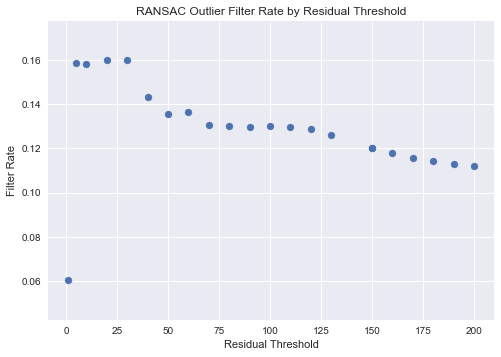

In [ ]:
plt.scatter(x = thres_choose['Threshold'], y = 1 - thres_choose['df_len']/len(df_merged_2))
plt.xlabel("Residual Threshold")
plt.ylabel("Filter Rate")
plt.title("RANSAC Outlier Filter Rate by Residual Threshold")
plt.show()

In [ ]:
list_df_filtered = []
for i in range(len(inverter_list)):
    df_temp = list_df_inverter[i]
    X_temp = df_temp['IRRADIATION'].values.reshape(-1,1)
    Y_temp = df_temp['AC_POWER'].values.reshape(-1,1)
    lr_temp = RANSACRegressor( residual_threshold = 30, random_state = 0).fit(X_temp, Y_temp)
    lr_pred_temp = lr_temp.predict(X_temp)
    a = lr_temp.estimator_.coef_[0,0]
    b = -1
    c = 0
    Distance = abs( a*X_temp + b*Y_temp + c ) / (np.sqrt( a*a + b*b))
    Dis = Distance.reshape(-1)
    dis_iqr = stats.iqr(Dis)
    TF_dis = Distance < ( pd.Series(Dis).quantile(0.75) + 1.5*dis_iqr)
    TF_dis = TF_dis.reshape(-1)
    df_temp = df_temp.loc[TF_dis, :]
    list_df_filtered.append(df_temp)
df_filter = pd.concat(list_df_filtered)
plt.scatter(x = df_filter.loc[:,'IRRADIATION'], y = df_filter.loc[:,'AC_POWER'])
plt.xlabel("Irradiation")
plt.ylabel("Target/AC Power in kW")
plt.title("AC Output by Irradiation after Filtering")
plt.show()

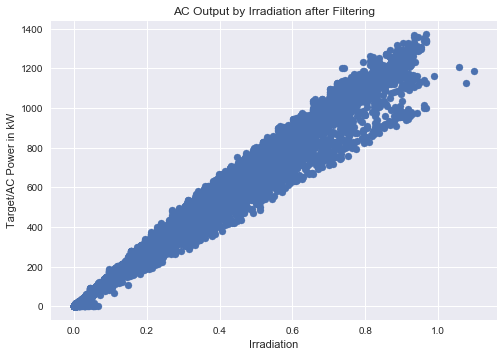

In [ ]:
plt.scatter(x = df_filter.loc[:,'IRRADIATION'], y = df_filter.loc[:,'AC_POWER'])
plt.xlabel("Irradiation")
plt.ylabel("Target/AC Power in kW")
plt.title("AC Output by Irradiation after Filtering")
plt.show()

In [ ]:
# df_input = df_filter.copy()
# df_input = df_input[['AC_POWER','Inverter_ID','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','month','day_of_month','hour','minute','day_of_week']]
# scaler = MinMaxScaler()
# le = LabelEncoder()
# col_Inverter_ID = le.fit_transform(df_input['Inverter_ID'])
# df_input['Inverter_ID'] = col_Inverter_ID
# Input = df_input.iloc[:,1:]
# Target = df_input.iloc[:,0]
# Input_scaled = scaler.fit_transform(Input)
# Input_scaled  = pd.DataFrame(Input_scaled, columns = Input.columns)
# X = Input_scaled
# Y = Target 
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
df_input = df_filter.copy()
df_input = df_input[['AC_POWER','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','month','day_of_month','hour','minute','day_of_week']]
scaler = MinMaxScaler()
Input = df_input.iloc[:,1:]
Target = df_input.iloc[:,0]
Input_scaled = scaler.fit_transform(Input)
Input_scaled  = pd.DataFrame(Input_scaled, columns = Input.columns)
X = Input_scaled
Y = Target 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
start_time = timeit.default_timer()
parameters_svr = {'kernel':( 'linear','rbf', 'poly'), 
                  'C':[0.1, 1, 5], 'cache_size':[1000]}
svr = SVR()
clf_svr = GridSearchCV(svr, parameters_svr, n_jobs = -1, 
                       scoring = 'neg_mean_squared_error', cv = 3)
best_svr = clf_svr.fit(X_train, Y_train)
elapsed = timeit.default_timer() - start_time

In [ ]:
svr_model = best_svr.best_estimator_
svr_result = svr_model.predict(X_test)

In [ ]:
SVR_mse = metrics.mean_squared_error(Y_test, svr_result)
SVR_r2 = metrics.r2_score(Y_test, svr_result)
SVR_mae = metrics.mean_absolute_error(Y_test, svr_result)

In [ ]:
plt.scatter(X_test['IRRADIATION'], Y_test,  color='black')
plt.plot(X_test['IRRADIATION'], svr_result, color='blue', linewidth=1)

plt.xlabel("Irradiation")
plt.ylabel("Target/AC Power in kW")
plt.title("Random Forest")
plt.show()

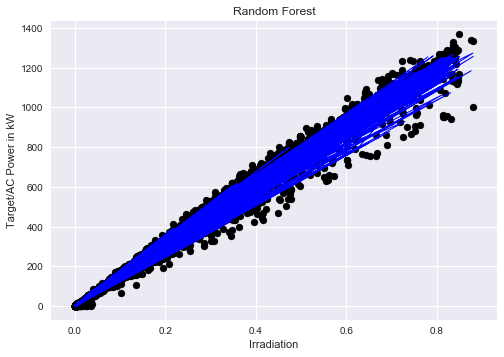

In [ ]:
plt.scatter(X_test['IRRADIATION'], Y_test,  color='black')
plt.plot(X_test['IRRADIATION'], RF_result, color='blue', linewidth=1)

plt.xlabel("Irradiation")
plt.ylabel("Target/AC Power in kW")
plt.title("Random Forest")
plt.show()

In [ ]:
SVR_r2 

0.99184426908019818

In [ ]:
SVR_mse

722.04939344999798

In [ ]:
SVR_mae

11.048329462533848

In [ ]:
start_time = timeit.default_timer()
parameters = {'n_estimators':(101,501,1001,2001), 'max_depth':(
    None,10), 'max_features':(None, 'sqrt')}
RF = RandomForestRegressor(random_state = 0)
clf = GridSearchCV(RF, parameters, n_jobs = -1, 
                   scoring = 'neg_mean_squared_error', cv = 3)
best_RF = clf.fit(X_train, Y_train)
elapsed = timeit.default_timer() - start_time

In [ ]:
RF_model = best_RF.best_estimator_
RF_result = RF_model.predict(X_test)

In [ ]:
RF_mse = metrics.mean_squared_error(Y_test, RF_result)
RF_r2 = metrics.r2_score(Y_test, RF_result)
RF_mae = metrics.mean_absolute_error(Y_test, RF_result)

In [ ]:
RF_mse

460.72143820936753

In [ ]:
RF_r2

0.99479603457449628

In [ ]:
RF_mae

7.9098685865858798

In [ ]:
RF_model.feature_importances_

array([ 0.04107594,  0.06802729,  0.02643357,  0.03439654,  0.5507253 ,
        0.0460428 ,  0.02240668,  0.02287253,  0.02433479,  0.05247398,
        0.02430223,  0.02749457,  0.05941379])

In [ ]:
df_ts = df_merged_2.copy()
t_time = df_ts['DATE_TIME']
t_1_time = t_time - dt.timedelta(days = 1)
t_2_time = t_time - dt.timedelta(days = 2)
t_3_time = t_time - dt.timedelta(days = 3)
df_t_1 = df_ts.loc[df_ts['DATE_TIME'].isin(t_1_time),:]
df_t_1['DATE_TIME_original'] = df_t_1['DATE_TIME'] + dt.timedelta(days = 1)
df_t_1 = df_t_1[['DATE_TIME_original','Inverter_ID','AC_POWER','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']]
df_t_1.columns = ['DATE_TIME','Inverter_ID','AC_POWER_1','AMBIENT_TEMPERATURE_1','MODULE_TEMPERATURE_1','IRRADIATION_1']
df_t_1.reset_index()
df_t_2 = df_ts.loc[df_ts['DATE_TIME'].isin(t_2_time),:]
df_t_2['DATE_TIME_original'] = df_t_2['DATE_TIME'] + dt.timedelta(days = 2)
df_t_2 = df_t_2[['DATE_TIME_original','Inverter_ID','AC_POWER','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']]
df_t_2.columns = ['DATE_TIME','Inverter_ID','AC_POWER_2','AMBIENT_TEMPERATURE_2','MODULE_TEMPERATURE_2','IRRADIATION_2']
df_t_2.reset_index()
df_t_3 = df_ts.loc[df_ts['DATE_TIME'].isin(t_3_time),:]
df_t_3['DATE_TIME_original'] = df_t_3['DATE_TIME'] + dt.timedelta(days = 3)
df_t_3 = df_t_3[['DATE_TIME_original','Inverter_ID','AC_POWER','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']]
df_t_3.columns = ['DATE_TIME','Inverter_ID','AC_POWER_3','AMBIENT_TEMPERATURE_3','MODULE_TEMPERATURE_3','IRRADIATION_3']
df_t_3.reset_index()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

index           DATE_TIME      Inverter_ID  AC_POWER_3  \
0          0 2020-05-18 00:00:00  4UPUqMRk7TRMgml         0.0   
1          1 2020-05-18 00:00:00  81aHJ1q11NBPMrL         0.0   
2          2 2020-05-18 00:00:00  9kRcWv60rDACzjR         0.0   
3          3 2020-05-18 00:00:00  Et9kgGMDl729KT4         0.0   
4          4 2020-05-18 00:00:00  IQ2d7wF4YD8zU1Q         0.0   
5          5 2020-05-18 00:00:00  LYwnQax7tkwH5Cb         0.0   
6          6 2020-05-18 00:00:00  LlT2YUhhzqhg5Sw         0.0   
7          7 2020-05-18 00:00:00  Mx2yZCDsyf6DPfv         0.0   
8          8 2020-05-18 00:00:00  NgDl19wMapZy17u         0.0   
9          9 2020-05-18 00:00:00  PeE6FRyGXUgsRhN         0.0   
10        10 2020-05-18 00:00:00  Qf4GUc1pJu5T6c6         0.0   
11        11 2020-05-18 00:00:00  Quc1TzYxW2pYoWX         0.0   
12        12 2020-05-18 00:00:00  V94E5Ben1TlhnDV         0.0   
13        13 2020-05-18 00:00:00  WcxssY2VbP4hApt         0.0   
14        14 2020-05-18 00:00:00  mqwcsP2rE7J0TFp         0.0   
15        15 2020-05-18 00:00:00  oZ35aAeoifZaQzV         0.0   
16        16 2020-05-18 00:00:00  oZZkBaNadn6DNKz         0.0   
17        17 2020-05-18 00:00:00  q49J1IKaHRwDQnt         0.0   
18        18 2020-05-18 00:00:00  rrq4fwE8jgrTyWY         0.0   
19        19 2020-05-18 00:00:00  vOuJvMaM2sgwLmb         0.0   
20        20 2020-05-18 00:00:00  xMbIugepa2P7lBB         0.0   
21        21 2020-05-18 00:00:00  xoJJ8DcxJEcupym         0.0   
22        22 2020-05-18 00:15:00  4UPUqMRk7TRMgml         0.0   
23        23 2020-05-18 00:15:00  81aHJ1q11NBPMrL         0.0   
24        24 2020-05-18 00:15:00  9kRcWv60rDACzjR         0.0   
25        25 2020-05-18 00:15:00  Et9kgGMDl729KT4         0.0   
26        26 2020-05-18 00:15:00  IQ2d7wF4YD8zU1Q         0.0   
27        27 2020-05-18 00:15:00  LYwnQax7tkwH5Cb         0.0   
28        28 2020-05-18 00:15:00  LlT2YUhhzqhg5Sw         0.0   
29        29 2020-05-18 00:15:00  Mx2yZCDsyf6DPfv         0.0   
...      ...                 ...              ...         ...   
57054  57108 2020-06-15 23:30:00  mqwcsP2rE7J0TFp         0.0   
57055  57109 2020-06-15 23:30:00  oZ35aAeoifZaQzV         0.0   
57056  57110 2020-06-15 23:30:00  oZZkBaNadn6DNKz         0.0   
57057  57111 2020-06-15 23:30:00  q49J1IKaHRwDQnt         0.0   
57058  57112 2020-06-15 23:30:00  rrq4fwE8jgrTyWY         0.0   
57059  57113 2020-06-15 23:30:00  vOuJvMaM2sgwLmb         0.0   
57060  57114 2020-06-15 23:30:00  xMbIugepa2P7lBB         0.0   
57061  57115 2020-06-15 23:30:00  xoJJ8DcxJEcupym         0.0   
57062  57116 2020-06-15 23:45:00  4UPUqMRk7TRMgml         0.0   
57063  57117 2020-06-15 23:45:00  81aHJ1q11NBPMrL         0.0   
57064  57118 2020-06-15 23:45:00  9kRcWv60rDACzjR         0.0   
57065  57119 2020-06-15 23:45:00  Et9kgGMDl729KT4         0.0   
57066  57120 2020-06-15 23:45:00  IQ2d7wF4YD8zU1Q         0.0   
57067  57121 2020-06-15 23:45:00  LYwnQax7tkwH5Cb         0.0   
57068  57122 2020-06-15 23:45:00  LlT2YUhhzqhg5Sw         0.0   
57069  57123 2020-06-15 23:45:00  Mx2yZCDsyf6DPfv         0.0   
57070  57124 2020-06-15 23:45:00  NgDl19wMapZy17u         0.0   
57071  57125 2020-06-15 23:45:00  PeE6FRyGXUgsRhN         0.0   
57072  57126 2020-06-15 23:45:00  Qf4GUc1pJu5T6c6         0.0   
57073  57127 2020-06-15 23:45:00  Quc1TzYxW2pYoWX         0.0   
57074  57128 2020-06-15 23:45:00  V94E5Ben1TlhnDV         0.0   
57075  57129 2020-06-15 23:45:00  WcxssY2VbP4hApt         0.0   
57076  57130 2020-06-15 23:45:00  mqwcsP2rE7J0TFp         0.0   
57077  57131 2020-06-15 23:45:00  oZ35aAeoifZaQzV         0.0   
57078  57132 2020-06-15 23:45:00  oZZkBaNadn6DNKz         0.0   
57079  57133 2020-06-15 23:45:00  q49J1IKaHRwDQnt         0.0   
57080  57134 2020-06-15 23:45:00  rrq4fwE8jgrTyWY         0.0   
57081  57135 2020-06-15 23:45:00  vOuJvMaM2sgwLmb         0.0   
57082  57136 2020-06-15 23:45:00  xMbIugepa2P7lBB         0.0   
57083  57137 2020-06-15 23:45:00  xoJJ8Dcx

In [ ]:
df_ts = df_ts[['DATE_TIME','Inverter_ID','AC_POWER']]

In [ ]:
df_ts = pd.merge(df_ts, df_t_1, how = 'right', on = ['DATE_TIME','Inverter_ID'])
df_ts = pd.merge(df_ts, df_t_2, how = 'right', on = ['DATE_TIME','Inverter_ID'])
df_ts = pd.merge(df_ts, df_t_3, how = 'right', on = ['DATE_TIME','Inverter_ID'])

In [ ]:
df_input = df_ts.copy()
df_input = df_input.dropna()
df_input = df_input[['AC_POWER','Inverter_ID','AC_POWER_1','AMBIENT_TEMPERATURE_1','MODULE_TEMPERATURE_1','IRRADIATION_1',
                     'AC_POWER_2','AMBIENT_TEMPERATURE_2','MODULE_TEMPERATURE_2','IRRADIATION_2','AC_POWER_3',
                     'AMBIENT_TEMPERATURE_3','MODULE_TEMPERATURE_3','IRRADIATION_3']]
le = LabelEncoder()
col_Inverter_ID = le.fit_transform(df_input['Inverter_ID'])
df_input['Inverter_ID'] = col_Inverter_ID
scaler = MinMaxScaler()
Input = df_input.iloc[:,1:]
Target = df_input.iloc[:,0]
Input_scaled = scaler.fit_transform(Input)
Input_scaled  = pd.DataFrame(Input_scaled, columns = Input.columns)
X = Input_scaled
Y = Target 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
df_input_ori = df_ts.copy()
df_input_ori = df_input_ori.dropna()
df_input = df_input_ori[['AC_POWER','Inverter_ID','AC_POWER_1','AMBIENT_TEMPERATURE_1','MODULE_TEMPERATURE_1','IRRADIATION_1','AC_POWER_2','AMBIENT_TEMPERATURE_2','MODULE_TEMPERATURE_2','IRRADIATION_2','AC_POWER_3','AMBIENT_TEMPERATURE_3','MODULE_TEMPERATURE_3','IRRADIATION_3']]
le = LabelEncoder()
col_Inverter_ID = le.fit_transform(df_input['Inverter_ID'])
df_input['Inverter_ID'] = col_Inverter_ID
scaler = MinMaxScaler()
Input = df_input.iloc[:,1:]
Target = df_input.iloc[:,0]
Input_scaled = scaler.fit_transform(Input)
Input_scaled  = pd.DataFrame(Input_scaled, columns = Input.columns)
X = Input_scaled
Y = Target 
X_train = X.loc[df_input_ori['DATE_TIME'] < '2020-06-10',:]
Y_train = Y.loc[df_input_ori['DATE_TIME'] < '2020-06-10']
X_test = X.loc[df_input_ori['DATE_TIME'] >= '2020-06-10',:]
Y_test = Y.loc[df_input_ori['DATE_TIME'] >= '2020-06-10']

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
len(Y_train)

41918

In [ ]:
start_time = timeit.default_timer()
parameters = {'n_estimators':[100,500,800,1000]}
RF = RandomForestRegressor(random_state = 0)
clf = GridSearchCV(RF, parameters, n_jobs = -1, scoring = 'neg_mean_squared_error', cv = 3)
best_RF = clf.fit(X_train, Y_train)
elapsed = timeit.default_timer() - start_time

In [ ]:
RF_model = best_RF.best_estimator_
RF_result = RF_model.predict(X_test)

In [ ]:
RF_mse = metrics.mean_squared_error(Y_test, RF_result)
RF_r2 = metrics.r2_score(Y_test, RF_result)
RF_mae = metrics.mean_absolute_error(Y_test, RF_result)

In [ ]:
Rf_forecast = pd.DataFrame({'Actual': Y_test, 'Predicted': RF_result})
Date_time = df_ts[['DATE_TIME','Inverter_ID']]
Rf_forecast = Rf_forecast.merge(Date_time, left_index = True, right_index = True)

In [ ]:
Rf_forecast['DATE_TIME']= pd.to_datetime(Rf_forecast.DATE_TIME)
Rf_forecast = Rf_forecast.loc[(Rf_forecast['DATE_TIME'] > '2020-06-12' )& 
                              (Rf_forecast['Inverter_ID'] == 'xMbIugepa2P7lBB'),:]

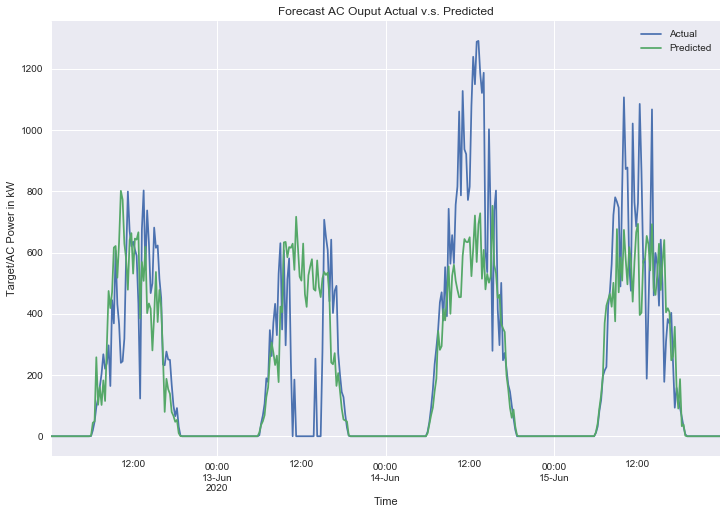

In [ ]:
Rf_forecast.plot(x = 'DATE_TIME',figsize=(12,8))
plt.xlabel("Time")
plt.ylabel("Target/AC Power in kW")
plt.title("Forecast AC Ouput Actual v.s. Predicted")
plt.show()

In [ ]:
plt.plot(x = Rf_forecast['DATE_TIME'], y = Rf_forecast['DATE_TIME'])

In [ ]:
df_merged_2[((df_merged_2['Inverter_ID'] == 'Et9kgGMDl729KT4') & (df_merged_2['DATE_TIME'] > '2020-05-25') & (df_merged_2['DATE_TIME'] < '2020-05-26'))].plot(x = 'DATE_TIME', y = 'AC_POWER', kind = 'scatter', color = 'red',figsize=(10,5))
df_merged_2[((df_merged_2['Inverter_ID'] == 'Mx2yZCDsyf6DPfv') & (df_merged_2['DATE_TIME'] > '2020-05-25') & (df_merged_2['DATE_TIME'] < '2020-05-26'))].plot(x = 'DATE_TIME', y = 'AC_POWER', kind = 'scatter',figsize=(10,5))
plt.show()

ValueError: scatter requires x column to be numeric

In [ ]:
aaa = df_merged_2[((df_merged_2['Inverter_ID'] == 'Et9kgGMDl729KT4') & (df_merged_2['DATE_TIME'] > '2020-05-25') & (df_merged_2['DATE_TIME'] < '2020-05-26'))]
bbb = df_merged_2[((df_merged_2['Inverter_ID'] == 'Mx2yZCDsyf6DPfv') & (df_merged_2['DATE_TIME'] > '2020-05-25') & (df_merged_2['DATE_TIME'] < '2020-05-26'))]
plt.scatter(x = )
plt.show()

In [ ]:
Rf_forecast

Actual   Predicted
20887     0.000000  128.509890
21857     0.000000    0.000000
54692     0.000000    0.000000
58357     2.807143    3.316799
56431     0.000000    0.000000
21321     0.000000    0.000000
57676   467.953333  476.913065
56275     0.000000    0.000000
8046      0.000000    0.000000
33890     0.000000    0.000000
16102    58.600000   51.846311
49138   530.392857  453.104140
42016     0.000000    0.000000
30734   275.960000  280.943134
12465   562.453333  602.616226
26969     0.000000    0.000000
45005   594.093333  666.689942
35022   219.235714  215.352072
3745      0.000000    0.000000
6016    872.571429  375.015389
25725    25.813333   25.556520
30940     0.000000    0.386453
25480     0.000000    0.000000
12513   277.750000  322.510688
21602     0.000000    0.000000
47779    32.173333   30.880954
28309     0.000000  377.894234
11591     0.000000    0.000000
24889     0.000000    0.000000
7006      0.000000    0.000000
...            ...         ...
40681   352.620000  482.074594
15521  1062.400000  468.729758
6818      0.000000    0.000000
56009   236.453333  253.709690
35301     0.000000    0.000000
2762    462.240000  444.043052
48036     0.000000    0.000000
39922     0.000000    0.000000
45290   489.853333  484.772718
24755     0.000000    0.000000
528       0.000000    0.009907
55100     0.000000    0.000000
16268     0.000000    0.000000
41465     1.180000    0.975745
18418     0.000000    0.000000
23859    85.953333   95.588506
3594      5.160000    6.589255
54751     0.000000    0.000000
2177      0.000000    0.000000
16897     0.000000    0.000000
24046   903.973333  787.627101
35299     0.000000    0.000000
4858   1010.133333  733.356766
8709      0.000000  245.576636
22370   846.640000  746.671795
57097     0.000000    0.000000
822     650.900000  645.750673
12789     0.000000    0.000000
39925     0.000000    0.000000
48328     0.000000    0.000000

[11763 rows x 2 columns]

## End

In [ ]:
#svr
elapsed

734.7228035

In [ ]:
#RF
elapsed

549.6943331999937

In [ ]:
output

{'MSE': [376.78129105105967, 362.497433686367, 3.6730217208621291e-11],
 'Model': ['SVR', 'Linear_Regression', 'Random Forest'],
 'R2': [0.99606841104882549, 0.99624154612774918, 0.99999999999999967]}

In [ ]:
#lr_mse = metrics.mean_squared_error(lr_y, lr_result)
#lr_r2 = metrics.r2_score(lr_y, lr_result)
svr_mse = metrics.mean_squared_error(Y_test, svr_result)
svr_r2 = metrics.r2_score(Y_test, svr_result)
RF_mse = metrics.mean_squared_error(Y_test, RF_result)
RF_r2 = metrics.r2_score(Y_test, RF_result)
output = {'Model':['SVR','Random Forest'], 'MSE': [svr_mse,  RF_mse], 'R2' : [svr_r2,  RF_r2]}

In [ ]:
output

{'MSE': [828.56959684928199, 257.80908150774354],
 'Model': ['SVR', 'Random Forest'],
 'R2': [0.9930445809445736, 0.99783582428681949]}

In [ ]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [ ]:
# calculate each actual data point's distance with the fitted line, this could be used as way to filter good and bad performing data points
a = lr_temp.estimator_.coef_[0,0]
b = 0
c = 0
Distance = abs( a*X_temp + b*Y_temp + c ) / (np.sqrt( a*a + b*b))

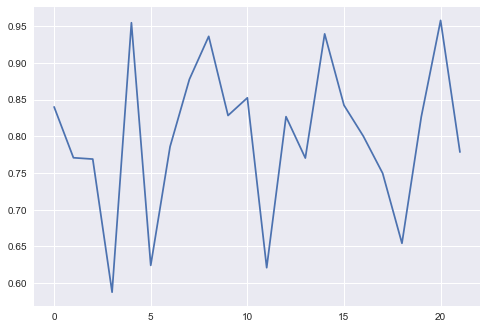

In [ ]:
plt.plot(list(df_corr['corr_coef']))
plt.show()

In [ ]:
df_plant_1 =df_merged_2.copy()

In [ ]:
df_plant_1['Light_conversion'] = df_plant_1['DC_POWER'] / df_plant_1['IRRADIATION']
df_plant_1['Light_conversion'] = df_plant_1['Light_conversion'].fillna(0)
df_plant_1['DCAC_conversion'] = df_plant_1['AC_POWER'] / df_plant_1['DC_POWER']
df_plant_1['DCAC_conversion'] = df_plant_1['DCAC_conversion'].fillna(0)

In [ ]:
inverter_group = df_plant_1.groupby(df_plant_1.Inverter_ID)
list_df_inverter = [] # the list used in
inverter_list = list(set(df_plant_1.Inverter_ID))

In [ ]:
for inv in inverter_list:
    df_temp = inverter_group.get_group(inv)
    list_df_inverter.append(df_temp)

In [ ]:
list_df_inverter[0].plot(x='time', y = 'Light_conversion' , style='b.', figsize=(15,5))
list_df_inverter[0].groupby('time')['Light_conversion'].agg('mean').plot(legend=True, colormap='Reds_r')
plt.title('Daily Light_conversion MEAN (RED)')
plt.ylabel('Light to DC conversion rate')
plt.show()

KeyError: 'time'

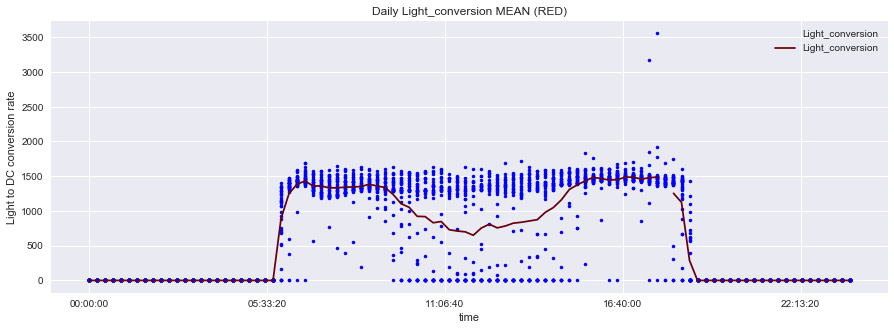

In [ ]:
list_df_inverter[1].plot(x='time', y = 'Light_conversion' , style='b.', figsize=(15,5))
list_df_inverter[1].groupby('time')['Light_conversion'].agg('mean').plot(legend=True, colormap='Reds_r')
plt.title('Daily Light_conversion MEAN (RED)')
plt.ylabel('Light to DC conversion rate')
plt.show()

## Evaluate the efficiency of different inverters
Through the below 2 charts we could identify inverters with high or low efficiency in terms of DC output.
We could see that inverter 'Quc1TzYxW2pYoWX' and 'Et9kgGMDl729KT4' have significantly lower efficiency compared to others and 'Mx2yZCDsyf6DPfv' has the best efficiency.

In [ ]:
print(set(df_plant_1['Inverter_ID']))

{'LYwnQax7tkwH5Cb', 'q49J1IKaHRwDQnt', 'vOuJvMaM2sgwLmb', '81aHJ1q11NBPMrL', 'IQ2d7wF4YD8zU1Q', 'oZZkBaNadn6DNKz', 'xoJJ8DcxJEcupym', 'Qf4GUc1pJu5T6c6', 'V94E5Ben1TlhnDV', 'xMbIugepa2P7lBB', 'rrq4fwE8jgrTyWY', '9kRcWv60rDACzjR', 'oZ35aAeoifZaQzV', 'NgDl19wMapZy17u', 'Mx2yZCDsyf6DPfv', 'PeE6FRyGXUgsRhN', 'WcxssY2VbP4hApt', 'Quc1TzYxW2pYoWX', 'Et9kgGMDl729KT4', 'LlT2YUhhzqhg5Sw', '4UPUqMRk7TRMgml', 'mqwcsP2rE7J0TFp'}


In [ ]:
Light_conv = df_plant_1.loc[df_plant_1['DC_POWER']>0,:].pivot_table(values='Light_conversion', index='time', columns='Inverter_ID')
Light_conv.boxplot(figsize=(15,5), grid=False, rot=90)
plt.title('Distribution of Light to DC Power Conversion (0 Removed) by Inverters')
plt.ylabel('Conversion Rate')
plt.show()

KeyError: 'time'

In [ ]:
DC_output = df_plant_1.loc[df_plant_1['DC_POWER']>0,:].pivot_table(values='DC_POWER', index='time', columns='Inverter_ID')
DC_output.boxplot(figsize=(15,5), grid=False, rot=90)
plt.title('Distribution of DC Output (0 Removed) by Inverters')
plt.ylabel('Conversion Rate')
plt.show()

## Evaluate the efficiency of different inverters
The below 2 graphs show the DC and AC output of the selected high and low performing inverters.
The gap beteween these inverters could be casued by 2 factors：
1. Irradiation to DC power conversion, which may imply problems within the photovoltaics process aka the panels
2. DC to AC power conversion, which may imply problems within the inverter itself

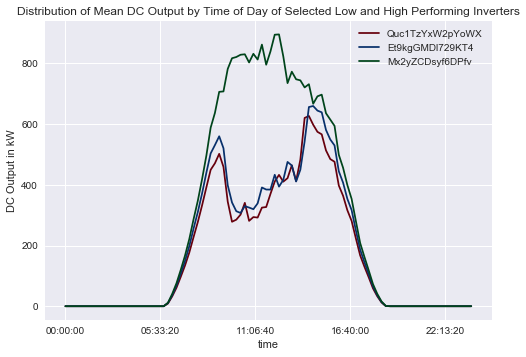

In [ ]:
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Quc1TzYxW2pYoWX',:].groupby('time')['DC_POWER'].agg('mean').plot(legend=True, colormap='Reds_r', label = 'Quc1TzYxW2pYoWX')
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Et9kgGMDl729KT4',:].groupby('time')['DC_POWER'].agg('mean').plot(legend=True, colormap='Blues_r', label = 'Et9kgGMDl729KT4')
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',:].groupby('time')['DC_POWER'].agg('mean').plot(legend=True, colormap='Greens_r', label = 'Mx2yZCDsyf6DPfv')
plt.title('Distribution of Mean DC Output by Time of Day of Selected Low and High Performing Inverters')
plt.ylabel('DC Output in kW')
plt.show()

In [ ]:
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Quc1TzYxW2pYoWX',:].groupby('time')['AC_POWER'].agg('mean').plot(legend=True, colormap='Reds_r', label = 'Quc1TzYxW2pYoWX')
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Et9kgGMDl729KT4',:].groupby('time')['AC_POWER'].agg('mean').plot(legend=True, colormap='Blues_r', label = 'Et9kgGMDl729KT4')
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',:].groupby('time')['AC_POWER'].agg('mean').plot(legend=True, colormap='Greens_r', label = 'Mx2yZCDsyf6DPfv')
plt.title('Distribution of AC Output by Time of Day of Selected Low and High Performing Inverters')
plt.ylabel('AC Output in kW')
plt.show()

## Evaluate the efficiency of different inverters
We further investigate on the 2 conversion rates we mentioned above. 
1. Across the entire day the irradiation to DC conversion rate has significant gap between the high performing and low performing inverters. This further indicates that systematic differences persist between panels connected to thees inverters
2. For the DC to AC conversion rate graph, we could observe that the high performing inverter (adLQvlD726eNBSB) has a almost constant DC to AC conversion rate while the low performing ones have depression area during the time where irradiation/outputs is strongest

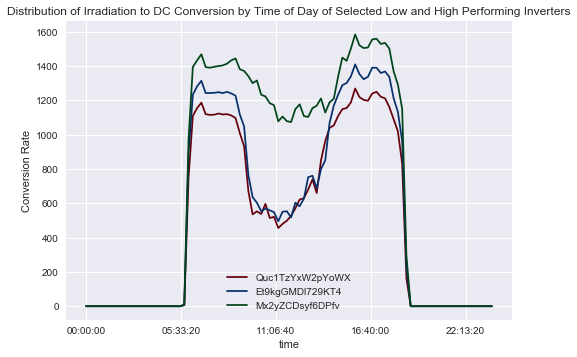

In [ ]:
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Quc1TzYxW2pYoWX',:].groupby('time')['Light_conversion'].agg('mean').plot(legend=True, colormap='Reds_r', label = 'Quc1TzYxW2pYoWX')
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Et9kgGMDl729KT4',:].groupby('time')['Light_conversion'].agg('mean').plot(legend=True, colormap='Blues_r', label = 'Et9kgGMDl729KT4')
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',:].groupby('time')['Light_conversion'].agg('mean').plot(legend=True, colormap='Greens_r', label = 'Mx2yZCDsyf6DPfv')
plt.title('Distribution of Irradiation to DC Conversion by Time of Day of Selected Low and High Performing Inverters')
plt.ylabel('Conversion Rate')
plt.show()

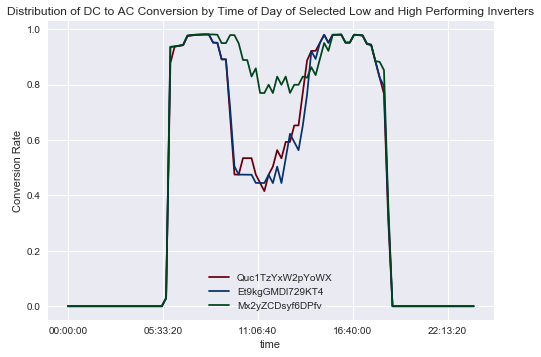

In [ ]:
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Quc1TzYxW2pYoWX',:].groupby('time')['DCAC_conversion'].agg('mean').plot(legend=True, colormap='Reds_r',label = 'Quc1TzYxW2pYoWX')
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Et9kgGMDl729KT4',:].groupby('time')['DCAC_conversion'].agg('mean').plot(legend=True, colormap='Blues_r', label = 'Et9kgGMDl729KT4')
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',:].groupby('time')['DCAC_conversion'].agg('mean').plot(legend=True, colormap='Greens_r', label = 'Mx2yZCDsyf6DPfv')
plt.title('Distribution of DC to AC Conversion by Time of Day of Selected Low and High Performing Inverters')
plt.ylabel('Conversion Rate')
plt.show()

In [ ]:
# df_plant_1.loc[df_plant_1['Inverter_ID'] == 'bvBOhCH3iADSZry',:].groupby('date')['TOTAL_YIELD'].agg('mean').plot(legend=True, colormap='Reds_r', label = 'bvBOhCH3iADSZry')
# df_plant_1.loc[df_plant_1['Inverter_ID'] == '1BY6WEcLGh8j5v7',:].groupby('date')['TOTAL_YIELD'].agg('mean').plot(legend=True, colormap='Blues_r', label = '1BY6WEcLGh8j5v7')
# df_plant_1.loc[df_plant_1['Inverter_ID'] == 'adLQvlD726eNBSB',:].groupby('date')['TOTAL_YIELD'].agg('mean').plot(legend=True, colormap='Greens_r', label = 'adLQvlD726eNBSB')
# plt.title('Total Yield by Dates of Selected Low and High Performing Inverters')
# plt.ylabel('Total Yield')
# plt.show()

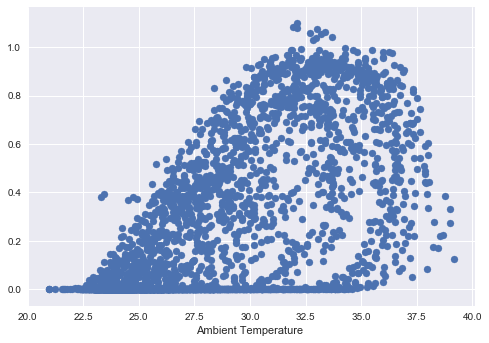

In [ ]:
#plt.scatter(df_weather_1.loc[df_weather_1['IRRADIATION']>0.01,'AMBIENT_TEMPERATURE'],df_weather_1.loc[df_weather_1['IRRADIATION']>0.01,'IRRADIATION'])
plt.scatter(df_weather_1['AMBIENT_TEMPERATURE'],df_weather_1['IRRADIATION'])
plt.xlabel('Ambient Temperature ')
plt.show()

In [ ]:
weather_clus = df_weather_1[['AMBIENT_TEMPERATURE','IRRADIATION']]
scaler = MinMaxScaler()
weather_clus_t = scaler.fit_transform(weather_clus)
weather_clus_t = pd.DataFrame({'AMBIENT_TEMPERATURE':weather_clus_t[:, 0], 'IRRADIATION': weather_clus_t[:, 1]})
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(weather_clus_t)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
km = KMeans(n_clusters=4)
km = km.fit(weather_clus_t)
weather_clus_t['Label'] = km.labels_
weather_clus_t.head()

AMBIENT_TEMPERATURE  IRRADIATION  Label
0                0.332381     0.000000      1
1                0.325585     0.000000      1
2                0.314688     0.000000      1
3                0.304739     0.000000      1
4                0.309978     0.000000      1
5                0.305405     0.000000      1
6                0.304396     0.000000      1
7                0.300343     0.000000      1
8                0.299330     0.000000      1
9                0.289688     0.000000      1
10               0.291570     0.000000      1
11               0.293622     0.000000      1
12               0.295290     0.000000      1
13               0.285994     0.000000      1
14               0.281597     0.000000      1
15               0.277364     0.000000      1
16               0.260692     0.000000      1
17               0.256881     0.000000      1
18               0.248895     0.000000      1
19               0.235127     0.000000      1
20               0.228914     0.000000      1
21               0.227503     0.000000      1
22               0.217914     0.000000      1
23               0.208281     0.002583      1
24               0.208364     0.011797      1
25               0.209522     0.019147      1
26               0.210751     0.038621      1
27               0.225111     0.094193      1
28               0.259376     0.181522      1
29               0.281505     0.289111      3
...                   ...          ...    ...
3229             0.366359     0.165427      1
3230             0.357275     0.108659      1
3231             0.304626     0.029081      1
3232             0.265200     0.078165      1
3233             0.285136     0.081449      1
3234             0.282319     0.059594      1
3235             0.260110     0.037782      1
3236             0.235375     0.020159      1
3237             0.199574     0.012189      1
3238             0.165771     0.002398      1
3239             0.142855     0.000000      1
3240             0.138722     0.000000      1
3241             0.140079     0.000000      1
3242             0.145859     0.000000      1
3243             0.149279     0.000000      1
3244             0.145775     0.000000      1
3245             0.150508     0.000000      1
3246             0.153958     0.000000      1
3247             0.154066     0.000000      1
3248             0.157311     0.000000      1
3249             0.162116     0.000000      1
3250             0.161227     0.000000      1
3251             0.154902     0.000000      1
3252             0.148798     0.000000      1
3253             0.147250     0.000000      1
3254             0.140868     0.000000      1
3255             0.139254     0.000000      1
3256             0.132262     0.000000      1
3257             0.128770     0.000000      1
3258             0.123935     0.000000      1

[3259 rows x 3 columns]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


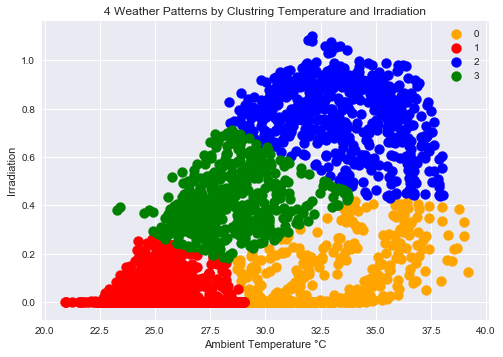

In [ ]:
cdict = {0:'orange' ,1: 'red', 2: 'blue', 3: 'green'}
weather_clus['Label'] = weather_clus_t['Label']
#weather_clus = weather_clus.set_index(df_weather_1['DATE_TIME'])
weather_clus['DATE_TIME'] = df_weather_1['DATE_TIME']
group = np.array(weather_clus_t['Label'])
scatter_x = np.array(weather_clus['AMBIENT_TEMPERATURE'])
scatter_y = np.array(weather_clus['IRRADIATION'])
fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
ax.legend()
plt.title('4 Weather Patterns by Clustring Temperature and Irradiation')
plt.xlabel('Ambient Temperature °C')
plt.ylabel('Irradiation')
plt.show()

In [ ]:
df_plant_1 = pd.merge(left = df_plant_1, right = weather_clus[['Label','DATE_TIME']], on = 'DATE_TIME')

DATE_TIME  PLANT_ID      Inverter_ID  DC_POWER  AC_POWER  \
0     2020-05-15 00:00:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
1     2020-05-15 00:00:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
2     2020-05-15 00:00:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
3     2020-05-15 00:00:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
4     2020-05-15 00:00:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
5     2020-05-15 00:00:00   4136001  LYwnQax7tkwH5Cb       0.0       0.0   
6     2020-05-15 00:00:00   4136001  LlT2YUhhzqhg5Sw       0.0       0.0   
7     2020-05-15 00:00:00   4136001  Mx2yZCDsyf6DPfv       0.0       0.0   
8     2020-05-15 00:00:00   4136001  NgDl19wMapZy17u       0.0       0.0   
9     2020-05-15 00:00:00   4136001  PeE6FRyGXUgsRhN       0.0       0.0   
10    2020-05-15 00:00:00   4136001  Qf4GUc1pJu5T6c6       0.0       0.0   
11    2020-05-15 00:00:00   4136001  Quc1TzYxW2pYoWX       0.0       0.0   
12    2020-05-15 00:00:00   4136001  V94E5Ben1TlhnDV       0.0       0.0   
13    2020-05-15 00:00:00   4136001  WcxssY2VbP4hApt       0.0       0.0   
14    2020-05-15 00:00:00   4136001  mqwcsP2rE7J0TFp       0.0       0.0   
15    2020-05-15 00:00:00   4136001  oZ35aAeoifZaQzV       0.0       0.0   
16    2020-05-15 00:00:00   4136001  oZZkBaNadn6DNKz       0.0       0.0   
17    2020-05-15 00:00:00   4136001  q49J1IKaHRwDQnt       0.0       0.0   
18    2020-05-15 00:00:00   4136001  rrq4fwE8jgrTyWY       0.0       0.0   
19    2020-05-15 00:00:00   4136001  vOuJvMaM2sgwLmb       0.0       0.0   
20    2020-05-15 00:00:00   4136001  xMbIugepa2P7lBB       0.0       0.0   
21    2020-05-15 00:00:00   4136001  xoJJ8DcxJEcupym       0.0       0.0   
22    2020-05-15 00:15:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
23    2020-05-15 00:15:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
24    2020-05-15 00:15:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
25    2020-05-15 00:15:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
26    2020-05-15 00:15:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
27    2020-05-15 00:15:00   4136001  LYwnQax7tkwH5Cb       0.0       0.0   
28    2020-05-15 00:15:00   4136001  LlT2YUhhzqhg5Sw       0.0       0.0   
29    2020-05-15 00:15:00   4136001  Mx2yZCDsyf6DPfv       0.0       0.0   
...                   ...       ...              ...       ...       ...   
67668 2020-06-17 23:30:00   4136001  mqwcsP2rE7J0TFp       0.0       0.0   
67669 2020-06-17 23:30:00   4136001  oZ35aAeoifZaQzV       0.0       0.0   
67670 2020-06-17 23:30:00   4136001  oZZkBaNadn6DNKz       0.0       0.0   
67671 2020-06-17 23:30:00   4136001  q49J1IKaHRwDQnt       0.0       0.0   
67672 2020-06-17 23:30:00   4136001  rrq4fwE8jgrTyWY       0.0       0.0   
67673 2020-06-17 23:30:00   4136001  vOuJvMaM2sgwLmb       0.0       0.0   
67674 2020-06-17 23:30:00   4136001  xMbIugepa2P7lBB       0.0       0.0   
67675 2020-06-17 23:30:00   4136001  xoJJ8DcxJEcupym       0.0       0.0   
67676 2020-06-17 23:45:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
67677 2020-06-17 23:45:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
67678 2020-06-17 23:45:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
67679 2020-06-17 23:45:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
67680 2020-06-17 23:45:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
67681 2020-06-17 23:45:00   4136001  LYwnQax7tkwH5Cb       0.0       0.0   
67682 2020-06-17 23:45:00   4136001  LlT2YUhhzqhg5Sw       0.0       0.0   
67683 2020-06-17 23:45:00   4136001  Mx2yZCDsyf6DPfv       0.0       0.0   
67684 2020-06-17 23:45:00   4136001  NgDl19wMapZy17u       0.0       0.0   
67685 2020-06-17 23:45:00   4136001  PeE6FRyGXUgsRhN       0.0       0.0   
67686 2020-06-17 23:45:00   4136001  Qf4GUc1pJu5T6c6       0.0       0.0   
67687 2020-06-17 23:45:00   4136001  Quc1TzYxW2pYoWX       0.0       0.0   
67688 2020-06-17 23:45:00   4136001  V94E5Ben1TlhnDV       0.0  

In [ ]:
df_plant_1.loc[df_plant_1['Label'] == 0,:].groupby('Inverter_ID')['DC_POWER'].gg('mean')(legend=True, color='Orange',label = 0, kind = 'box')
df_plant_1.loc[df_plant_1['Label'] == 1,:].groupby('Inverter_ID')['DC_POWER'].agg('mean').plot(legend=True, color='Red',label = 1, kind = 'box')
df_plant_1.loc[df_plant_1['Label'] == 2,:].groupby('Inverter_ID')['DC_POWER'].agg('mean').plot(legend=True, color='Blue',label = 2, kind = 'box')
df_plant_1.loc[df_plant_1['Label'] == 3,:].groupby('Inverter_ID')['DC_POWER'].agg('mean').plot(legend=True, color='Green',label = 3, kind = 'box')
plt.show()

In [ ]:
df_plant_1.loc[df_plant_1['Label'] == 0,:].groupby('Inverter_ID')['DC_POWER'].agg('mean').plot(legend=True, color='Orange',label = 'Weather 0', style = '.')
df_plant_1.loc[df_plant_1['Label'] == 1,:].groupby('Inverter_ID')['DC_POWER'].agg('mean').plot(legend=True, color='Red',label = 'Weather 1', style = '.')
df_plant_1.loc[df_plant_1['Label'] == 2,:].groupby('Inverter_ID')['DC_POWER'].agg('mean').plot(legend=True, color='Blue',label = 'Weather 2', style = '.')
df_plant_1.loc[df_plant_1['Label'] == 3,:].groupby('Inverter_ID')['DC_POWER'].agg('mean').plot(legend=True, color='Green',label = 'Weather 3', style = '.')
plt.show()

In [ ]:
df_merged_2.loc[df_plant_1['Inverter_ID'] == 'Quc1TzYxW2pYoWX',:].groupby('time')['DCAC_conversion'].agg('mean').plot(legend=True, colormap='Reds_r',label = 'Quc1TzYxW2pYoWX')
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Et9kgGMDl729KT4',:].groupby('time')['DCAC_conversion'].agg('mean').plot(legend=True, colormap='Blues_r', label = 'Et9kgGMDl729KT4')
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',:]

In [ ]:
df_merged_2.loc[df_merged_2['Inverter_ID'] == 'Quc1TzYxW2pYoWX',:].plot(x='time', y = 'DC_POWER' , style='b.', figsize=(15,5))
df_merged_2.loc[df_merged_2['Inverter_ID'] == 'Quc1TzYxW2pYoWX',:].groupby('time')['DC_POWER' ].agg('mean').plot(legend=True, colormap='Reds_r')
plt.title('Daily Light_conversion MEAN (RED)')
plt.ylabel('Light to DC conversion rate')
plt.show()

KeyError: 'time'

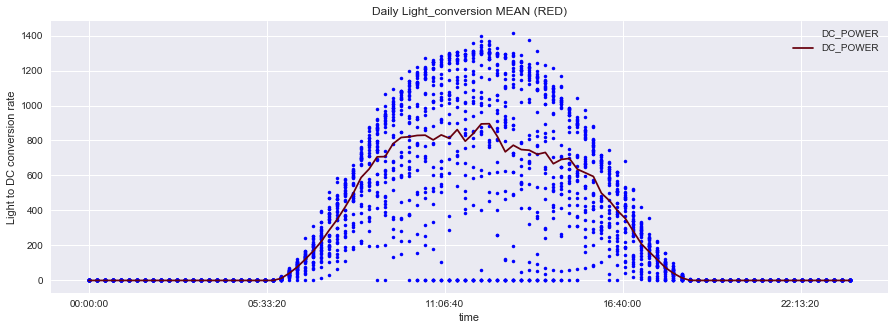

In [ ]:
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',:].plot(x='time', y = 'DC_POWER' , style='b.', figsize=(15,5))
df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',:].groupby('time')['DC_POWER' ].agg('mean').plot(legend=True, colormap='Reds_r')
plt.title('Daily Light_conversion MEAN (RED)')
plt.ylabel('Light to DC conversion rate')
plt.show()

In [ ]:
calendar_dc_bad = df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Quc1TzYxW2pYoWX',:].pivot_table(values='DC_POWER', index='time', columns='date')
calendar_dc_good = df_plant_1.loc[df_plant_1['Inverter_ID'] == 'Mx2yZCDsyf6DPfv',:].pivot_table(values='DC_POWER', index='time', columns='date')
calendar_dc_weather = df_plant_1.pivot_table(values='IRRADIATION', index='time', columns='date')

In [ ]:
#define function to multi plot

def multi_plot(data= None, row = None, col = None, title = None):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,20)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.8)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, style = 'k.')
        ax.set_title('{} {}'.format(title, cols[i-1]))

In [ ]:
multi_plot(data=calendar_dc_bad, row=9, col=4, title = 'DC Power for Bad Inverter')
plt.show()

In [ ]:
multi_plot(data=calendar_dc_weather, row=9, col=4, title = 'Irradiation')
plt.show()

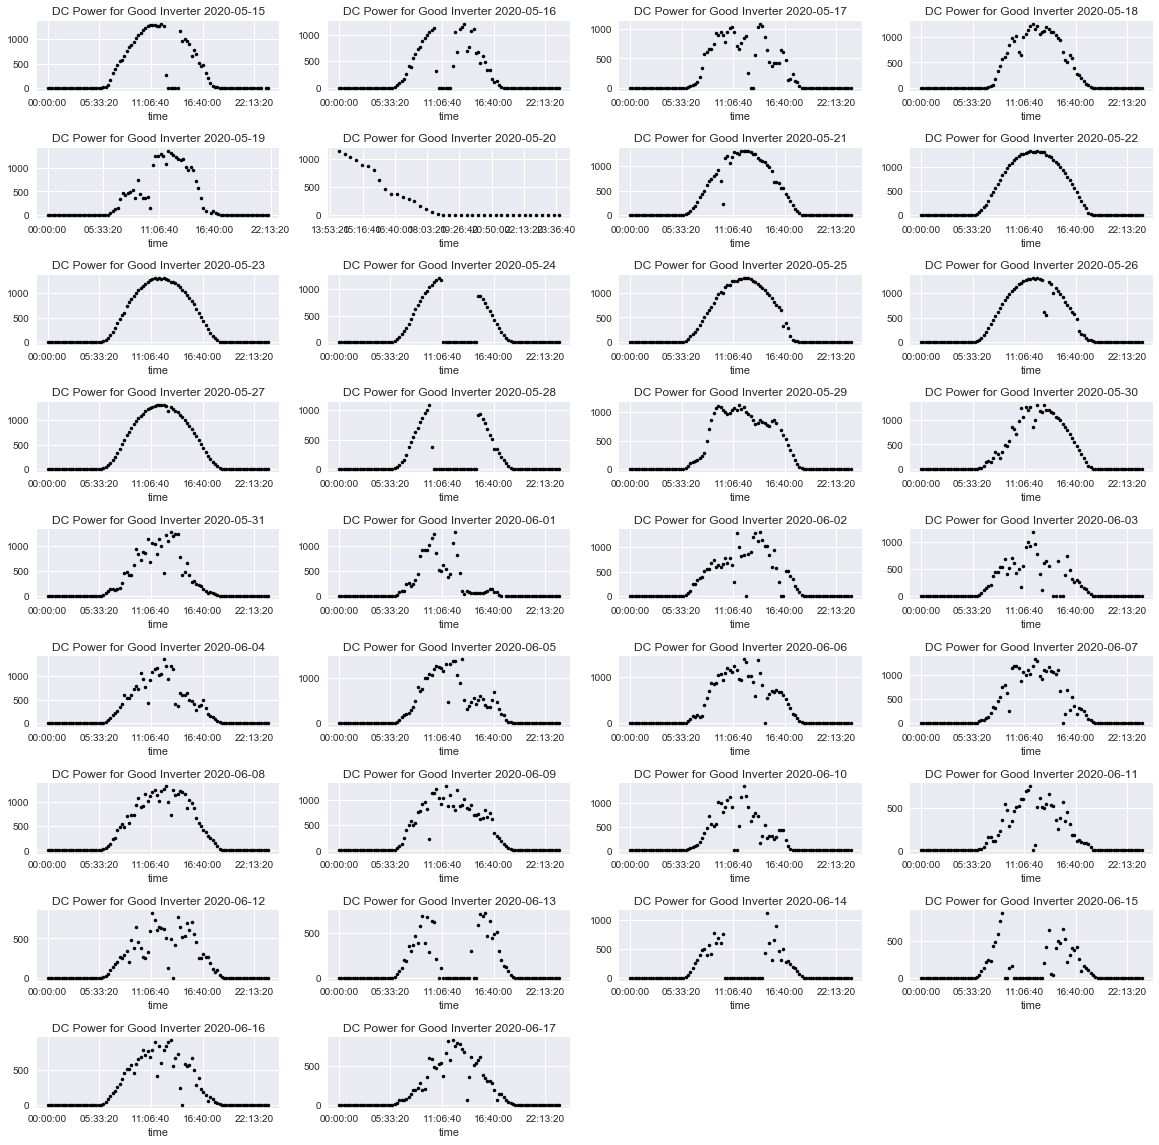

In [ ]:
multi_plot(data=calendar_dc_good, row=9, col=4, title = 'DC Power for Good Inverter')
plt.show()